# NICA in Continuous Time --  Simulations (Jupyter-Notebook)

This Jupyter-Notebook contains the simulations run in Section 8 of the paper 

**Nonlinear Independent Component Analysis for Continuous-Time Signals** by Harald Oberhauser and Alexander Schell 

(preprint available on arXiv). Any code that was used for these simulations is provided at https://github.com/alexander-schell/SigNICA.git. 

In [1]:
import numpy as np
import scipy
import scipy.linalg as la
from scipy import stats
import torch
from torch import nn
import torch.utils.data as Data
from torch.autograd import Variable
import signatory

# functionality for plots:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# import auxiliary functions:
import itertools
from itertools import permutations
from itertools import groupby
import time
import os
import pickle
# additional code:
import MonomialDiscordance as mondis
import SigIC as sigic
import SigIC_ANN as sigNN

# import R-functionality to Python:
import rpy2
import rpy2.robjects as ro
from   rpy2.robjects.packages import importr
from   rpy2.robjects import globalenv
r = ro.r
# import rpy2's package module: #
import rpy2.robjects.packages as rpackages

# activate conversion from numpy-arrays to R-vectors: 
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
# import R's 'base' and 'utils' library: 
base  = importr('base')
utils = importr('utils')
# select a mirror for R libraries #
utils.chooseCRANmirror(ind=1) # UK(London 1)

# R-packages:
# the copula-package of Emura et al.:
CopulaMarkov = utils.install_packages('Copula.Markov') 
importr('Copula.Markov')
# the sde-package of S.M. Iacus:
sde = utils.install_packages('sde')
importr('sde')

rpy2.robjects.packages.Package as a <module 'sde'>

## Experiments I : Planar Mixings with Explicitly Parametrised Inverses

As a first proof of concept, we consider three nonlinear mixings $f_1, f_2, f_3$ on the plane whose inverses $f_j^{-1}$ admit an explicit parametrisation.   

To visualize the transformative effect of each $f_j$, we plot its image of the square $[-1,1]^2$. 

Below is a plot of a regular grid on $[-1,1]^2$, which will be the spatial support of our first three source processes.

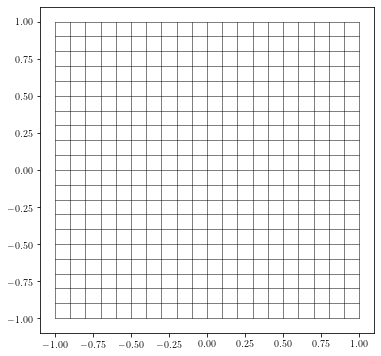

In [40]:
# Plot a regular 2d-grid on (-1,1)^2 using linspace:
x_range = range(-10,11)
y_range = range(-10,11)

lines = np.empty((len(x_range)+len(y_range), 2, 100))

for i in x_range: # vertical lines
    linspace_x = np.linspace(x_range[i], x_range[i], 100)
    linspace_y = np.linspace(min(y_range), max(y_range), 100)
    lines[i]   = (linspace_x, linspace_y)
for i in y_range: # horizontal lines
    linspace_x = np.linspace(min(x_range), max(x_range), 100)
    linspace_y = np.linspace(y_range[i], y_range[i], 100)
    lines[i+len(x_range)] = (linspace_x, linspace_y)
lines = lines/10

# Plot the grid:
plt.figure(figsize=(6,6))
plt.axis("on")
for line in lines:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")

### Definition of Planar Mixing Transformations

Next we define the first of our mixing transformations, $f_1$, which will be (sort of) a 'smooth conjugate' of a linear transform on $\mathbb{R}^2$. 

More specifically, we consider the transform $h_\theta:\mathbb{R}^2\rightarrow\mathbb{R}^2$ given by 

\begin{equation}\label{experI:eq1}\tag{1}
h_\theta(x_1, x_2):=\begin{pmatrix}
p_{\theta_1}(x_1) + x_2\\
-\theta_2\cdot x_1\end{pmatrix}\qquad\text{ with }\quad\text{ inverse }\qquad h_\theta^{-1}(x_1, x_2):=\begin{pmatrix}
-x_2/\theta_2\\
x_1 - p_{\theta_1}(-x_2/\theta_2)\end{pmatrix}\qquad\text{ for }\quad p_{\theta_1}(X):=X^3+\theta_1.
\end{equation}

The above map is known as the *Hénon map*, and it is a smooth diffeomorphism on the plane (for any polynomial $p_{\theta_1}$). 

Given $h_\theta$, we set 
\begin{equation}\label{experI:eq2}\tag{2}
f_1 \ = \ h_{(0,0.5)}\circ A \circ h^{-1}_{(0,1)} \qquad \text{ for the matrix } \qquad A = \begin{pmatrix}
0.77298565 \quad 0.63442351\\
0.63442351 \quad -0.77298565\end{pmatrix}.
\end{equation}

An implementation of \eqref{experI:eq1} and \eqref{experI:eq2} is given below.

In [12]:
'''Hénon Map and its Inverse:'''

# h_theta:
def HenonX3(x, theta):
    # i-th column of x is i-th coordinate (x_i)
    
    y      = np.zeros(np.shape(x))
    y[:,0] = x[:,0]**3 + theta[0] + x[:,1] # = f_1(x,y)
    y[:,1] = -theta[1]*x[:,0]              # = f_2(x,y)
    
    return y

# (h_theta)^{-1}:
def HenonX3Inv(x, theta):
    
    y      = np.zeros(np.shape(x))
    y[:,0] = -x[:,1]/theta[1]                         # = (f^{-1})_1(x,y)
    y[:,1] = x[:,0] - (-x[:,1]/theta[1])**3 - theta[0] # = (f^{-1})_2(x,y)
    
    return y


In [10]:
'''f_1:'''

# A:
A = np.asarray([[ 0.77298565,  0.63442351],
                [ 0.63442351, -0.77298565]])

def LinTrafo(B,x):
# input: dxd-matrix A (as (d,d)-array) and list x of argument vectors (rows) (as (n,d)-array)
# return: (A@vj)_j (--> (n,d)-array), where vj is the jth row of x
    y      = np.zeros(np.shape(x))
    z      = (B@(x.T)).T
    y[:,0] = z[:,0]
    y[:,1] = z[:,1]
    
    return y

# f_1:
def f_1(x):
# input: (n,d)-array x, where x=(x1,x2) (i.e., i-th column of x is i-th coordinate x_i)
# returns: f_1(x) (as (n,d)-array)
    return HenonX3(LinTrafo(A,HenonX3Inv(x, np.asarray([0,1]))), np.asarray([0,0.5]))


The second mixing transform is a linear transform composed with the topological conjugate of the map $h^{-1}_{(0,-0.35)}\circ h_{(0,0.5)}$ along the diffeo $A\circ h_{(0,1)}^{-1}$, i.e. 

\begin{equation}\label{experI:eq3}\tag{3}
f_2 \ = \ \tilde{f}_2\circ A_2 \qquad\text{for}\qquad \tilde{f}_2:=\varphi^{-1}\circ\big(h^{-1}_{(0,-0.35)}\circ h_{(0,0.5)}\big)\circ\varphi \quad \text{and}\quad \varphi:=A\circ h^{-1}_{(0,1)} \quad\text{and}\quad A_2 = \begin{pmatrix}
0.85163021 \quad 0.54409197\\
0.5233505  \quad 0.43698513\end{pmatrix}.
\end{equation}

An implementation of \eqref{experI:eq3} is given below.

In [5]:
'''f_2:'''

# A_2:
A2 = np.asarray([[0.85163021, 0.54409197],
                 [0.5233505 , 0.43698513]])
# A_2^{-1}:
B2 = np.linalg.inv(A2)

# \varphi and varphi^{-1}:
def varphi(x,theta):
    
    y1 = HenonX3Inv(x,theta)
    y2 = LinTrafo(A,y1)
    
    return y2

def varphiInv(x,theta):
    
    y1 = LinTrafo(A.T,x)
    y2 = HenonX3(y1,theta)
    
    return y2

# f_2:
def f_2(x):
    
    x  = LinTrafo(A2,x)
    y1 = varphi(x,np.asarray([0,1]))
    y2 = HenonX3(y1,np.asarray([0,0.5]))
    y3 = HenonX3Inv(y2,np.asarray([0,-.35]))
    y4 = varphiInv(y3,np.asarray([0,1]))
    
    return y4


The third mixing map is defined by way of the *Möbius transformations* $m_\theta : \mathbb{R}^2\setminus\{(-\frac{\theta_4}{\theta_3},0)\}\rightarrow\mathbb{R}^2\setminus\{(-\frac{\theta_1}{\theta_3},0)\}$ which we recall to be given by
\begin{equation}\tag{4}
m_{\theta}(x,y):=\begin{pmatrix}
\mathrm{Re}[\phi_\theta(x + \mathrm{i}y)]\\
\mathrm{Im}[\phi_\theta(x + \mathrm{i}y)]\end{pmatrix}\qquad\text{ with }\quad\text{ inverse }\qquad m_\theta^{-1}(x,y):=\begin{pmatrix}
\mathrm{Re}[\phi_\theta^{-1}(x + \mathrm{i}y)]\\
\mathrm{Im}[\phi_\theta^{-1}(x + \mathrm{i}y)]\end{pmatrix}
\end{equation}for the classical Möbius transforms (with real coefficients) $\phi_{\theta}:\mathbb{C}\setminus\{-\frac{\theta_4}{\theta_3}\}\rightarrow\mathbb{C}\setminus\{-\frac{\theta_1}{\theta_3}\}$ given by 
$$\phi_\theta(z):=\frac{\theta_1 z + \theta_2}{\theta_3 z + \theta_4}\qquad\text{ with }\quad\text{ inverse }\qquad\phi^{-1}_\theta(z):=\frac{\theta_4 z - \theta_2}{-\theta_3 z + \theta_1} \qquad\text{ for }\quad \theta\equiv\begin{pmatrix}
\theta_1 \quad \theta_2\\
\theta_3 \quad \theta_4\end{pmatrix}\in\operatorname{GL}_d(\mathbb{R}).$$

An implementation of $m_\theta$ is given below.

In [19]:
'''Moebius Transformations:'''

# m_theta:
def moeb(x, theta):
    
    y      = np.zeros(np.shape(x))
    z      = x[:,0] + x[:,1]*1j
    phi_z  = (theta[0]*z + theta[1])/(theta[2]*z + theta[3])
    y[:,0] = phi_z.real
    y[:,1] = phi_z.imag
    
    return y

# (m_theta)^{-1}:
def moebInv(x, theta):
    
    y        = np.zeros(np.shape(x))
    z        = x[:,0] + x[:,1]*1j
    phiInv_z = (theta[3]*z - theta[1])/(-theta[2]*z + theta[0])
    y[:,0]   = phiInv_z.real
    y[:,1]   = phiInv_z.imag
    
    return y

Given $m_\theta$ as above, we define the mixing transformation 
\begin{equation}\label{experI:eq5}\tag{5}
f_3 \ := \ m_{(1,0,2,1)}\circ A \circ m_{(1,0,-2,1)}^{-1} \qquad\text{ with }\qquad A_3 = \begin{pmatrix}
0.89467995 \quad 0.44670772\\
0.44670772 \quad -0.89467995\end{pmatrix}.
\end{equation}

In [6]:
'''f_3:'''

# A_3:
A3 = np.asarray([[ 0.89467995,  0.44670772],
                 [ 0.44670772, -0.89467995]])

# f_3:
th1_mix = np.asarray([1,0,-2,1])
th2_mix = np.asarray([1,0,2,1])

def f_3(x):
# input: (n,d)-array x, where x=(x1,x2) (i.e., i-th column of x is i-th coordinate x_i)
# returns: f_2(x)
    return moeb(LinTrafo(A3,moebInv(x,th1_mix)),th2_mix)


The above mixing transforms $f_1$, $f_2$ and $f_3$ are enumerated ascendingly with respect to their 'nonlinearity', as becomes apparent when considering their images $f_j([-1,1]^2)$ which are plotted below. (The following plot is exported as 'Figure 1' in the paper.)

Text(0.945, 0.945, '$(c)$')

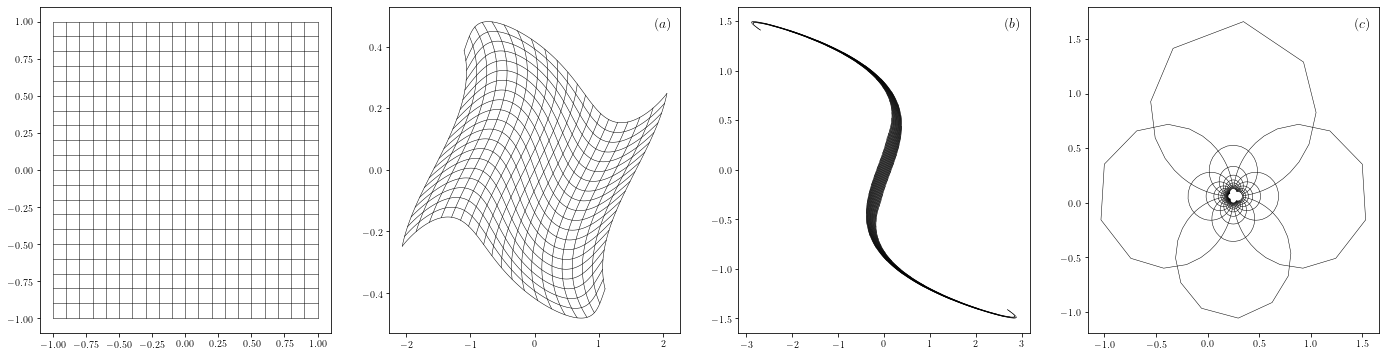

In [83]:
'''Planar Mixing Transformations for Experiment I'''

# compute images of standard-grid:
grid_f1 = f_1(lines)
grid_f2 = f_2(lines)
grid_f3 = f_3(lines)

# plot images f_j(grid):
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,6))

plt.axis("on")
for line in lines:
    axes[0].plot(line[0], line[1], linewidth=0.5, color="k")
    
for line in grid_f1:
    axes[1].plot(line[0], line[1], linewidth=0.5, color="k")
axes[1].text(0.945, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=axes[1].transAxes)

for line in grid_f2:
    axes[2].plot(line[0], line[1], linewidth=0.5, color="k")
axes[2].text(0.945, 0.945,'$(b)$', fontsize=14, ha='center', va='center', transform=axes[2].transAxes)

for line in grid_f3:
    axes[3].plot(line[0], line[1], linewidth=0.5, color="k")
axes[3].text(0.945, 0.945,'$(c)$', fontsize=14, ha='center', va='center', transform=axes[3].transAxes)


### Definition of $f_4 : \mathbb{R}^3\rightarrow\mathbb{R}^3$

As an additional mixing transformation, we define the diffeomorphism $f_4 : \mathbb{R}^3\rightarrow\mathbb{R}^3$ by

\begin{equation}\label{experI:eq6}\tag{6}
f_4 \ = \ A_4^{(2)}\circ (\alpha_1\times\alpha_2\times\alpha_3)\circ A_4^{(1)} \qquad\text{for}\qquad
\begin{pmatrix}
\alpha_1 \\
\alpha_2\\
\alpha_3 
\end{pmatrix} :=
\begin{pmatrix}
0.01e^{x_2} \\
-\theta_1\cdot x_3^3 \\
0.01\tanh(\theta_2\cdot x_1) 
\end{pmatrix} \quad \text{with}\quad (\theta_1,\theta_2)=(0.2,-5)
\end{equation} 

and two invertible matrices $A_4^{(1)}, A_4^{(2)}\in\operatorname{GL}_3(\mathbb{R})$ given below.

In [128]:
'''f_4:'''

# A_41:
A_41    = 0.2*np.asarray([[1,2,0], [2,4,1], [2,1,0]])
A_41inv = (5/3)*np.asarray([[-1,0,2], [2,0,-1], [-6,3,0]]) # = A_41^{-1}

# A_42:
A_42    = 100*np.asarray([[-0.07918701, -0.04009194,  0.99605324],
                          [-0.59270121,  0.80528814, -0.01470672],
                          [ 0.80152024,  0.59152654,  0.0875309 ]])
A_42inv = np.linalg.inv(A_42) # = A_42^{-1}

# linear transformation:
def linmap(B,x):
    
    y      = np.zeros(np.shape(x))
    z      = (B@(x.T)).T
    y[:,0] = z[:,0]
    y[:,1] = z[:,1]
    y[:,2] = z[:,2]
    
    return y

# a_1 x a_2 x a_3:
P = np.asarray([[0,1,0],[0,0,1],[1,0,0]]) # coordinate-permutation
def middlemap(x,theta):
    
    x      = linmap(P,x)
    y      = np.zeros(np.shape(x))
    y[:,0] = 0.01*np.exp(x[:,0])
    y[:,1] = -theta[0]*x[:,1]**3
    y[:,2] = 0.01*np.tanh(theta[1]*x[:,2])
    
    return y

# (a_1 x a_2 x a_3)^{-1}:
def middlemapInv(x,theta):
    
    y      = np.zeros(np.shape(x))
    y[:,0] = np.log(100*x[:,0])
    y[:,1] = np.cbrt(-x[:,1]/theta[0])
    y[:,2] = (1/theta[1])*np.arctanh(100*x[:,2])
    y      = linmap(P.T,y)
    
    return y

# f_4:
def f_4th(x,theta):
    
    y1 = linmap(A_41,x)
    y2 = middlemap(y1,theta)
    z  = linmap(A_42,y2)
    
    return z

# f_4^{-1}:
def f_4thinv(x,theta):
    
    y1 = linmap(A_42inv,x)
    y2 = middlemapInv(y1,theta)
    y3  = linmap(A_41inv,y2)
    
    return y3

def f_4(x):
    return f_4th(x,np.asarray([.2,-5]))


We visualize the map $f_4$ by plotting its action on the unit sphere. (The plots below are exported to 'Figure 4' of the paper.)

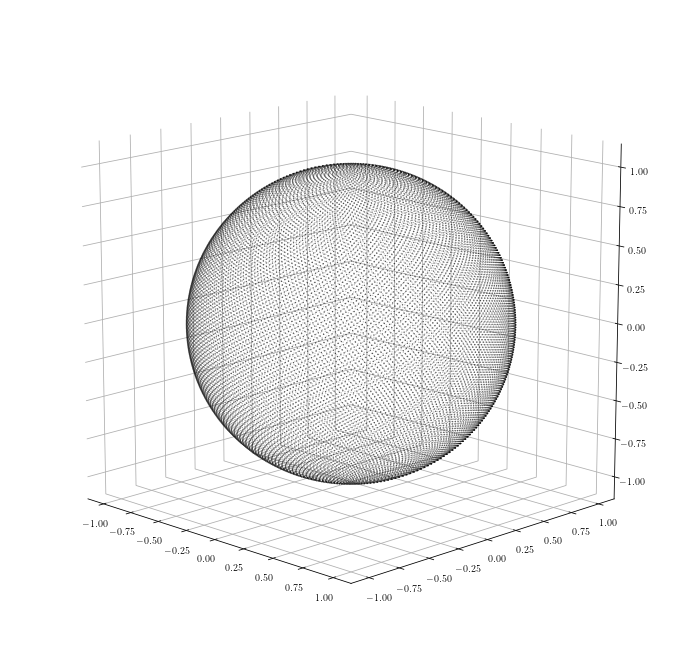

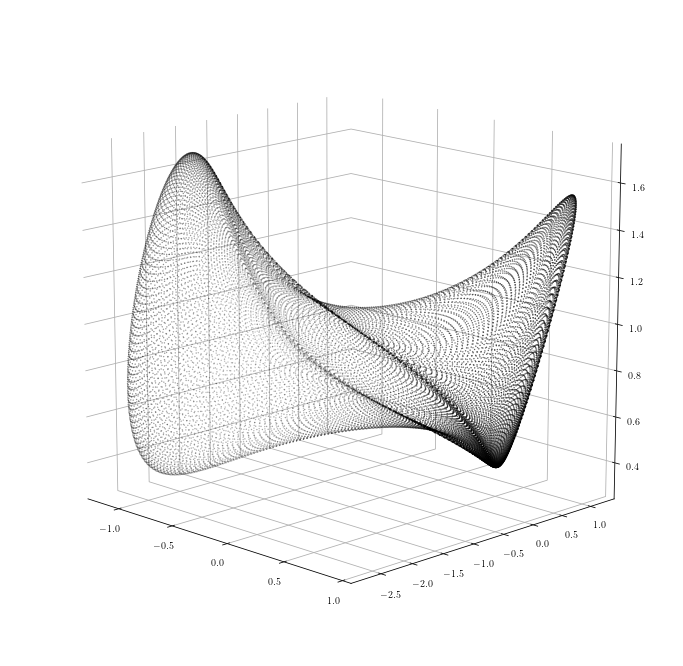

In [133]:
'''Unit Sphere'''

#%matplotlib notebook  #de-comment for a 3D-view of the following plots

from numpy import pi, cos, sin, arccos, arange
import mpl_toolkits.mplot3d
from matplotlib import cm
from itertools import product, combinations

# sample unit sphere ('sunflower sampling', see [1]):
num_pts = 25000
indices = arange(0, num_pts, dtype=float) + 0.5

phi     = arccos(1 - 2*indices/num_pts)
theta   = pi * (1 + 5**0.5) * indices

x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi);
w       = np.asarray([x,y,z]).T

# plot sampled unit sphere:
fig = plt.figure(figsize=plt.figaspect(1)*3)
ax  = fig.gca(projection='3d')
ax.scatter(w[:,0],w[:,1],w[:,2], s=0.1, c='black', rasterized=True)

# make the background-panes (of the 3D-plot) transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=15, azim=-45)
        
plt.show()

#plt.savefig('UnitSphere3D_dpi300.pdf', dpi=300)

'''f_4(Unit Sphere)'''

# apply f_4 to unit sphere:
q   = f_4(w)

fig = plt.figure(figsize=plt.figaspect(1)*3)
ax  = fig.gca(projection='3d')
ax.scatter(q[:,0],q[:,1],q[:,2], s=0.1, c='black', rasterized=True)

# make the panes (of the 3D-plot) transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=15, azim=-45)
        
plt.show()
#plt.savefig('MixingTransform3D_dpi300.pdf', dpi=300)

# References:
# [1] : https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere

## Generate the Source Processes

With the above mixing transforms $f_j$ ($j=1,\ldots,4$) in place, we apply them to source models with independent coordinate processes. 

We generate ($\alpha$- and $\beta$-contrastive) sources of two different kinds, namely:
- an IC Ornstein-Uhlenbeck process $S_\mathrm{ou}$ in $\mathbb{R}^2$ and $\mathbb{R}^3$;
- an IC time-series model $S_\mathrm{cy}$ in $\mathbb{R}^2$ and $\mathbb{R}^3$ which is based on the Clayton-copula (cf. paper).

For convenience, we simulate these sources (with $n=250 000$ data points each) using the specialised $\textsf{R}$-packages referenced below.  

### Planar Sources

In [49]:
'''Time-Series (IC) and Ornstein-Uhlenbeck (IC) in 2D'''

# Copula-based time series of Clayton type (source-type 1): 
r('''
set.seed(123)
nobs = 10000 # number of data points ('observations')

S1cy <- Clayton.Markov.DATA(n=nobs,mu=0,sigma=1,alpha=0.5)
S2cy <- Clayton.Markov.DATA(n=nobs,mu=0,sigma=1,alpha=1.5)
''')
S1cy = r('S1cy')
S2cy = r('S2cy')
S1cy = 1/(np.max(np.abs(S1cy)))*S1cy
S2cy = 1/(np.max(np.abs(S2cy)))*S2cy
S_cy = np.vstack((S1cy, S2cy)).transpose() # --> (nobs, d)-array

# Stationary Ornstein-Uhlenbeck processes (source-type 2):
r('''
set.seed(123)
# Source Component 1
th1_1 <- 0   #20
th1_2 <- 250 # Set high speed of reversion ("high stationarity")
th1_3 <- 1
d1 <- expression(th1_1 - th1_2 * x)
s1 <- expression(th1_3)
S1ou <- -5*sde.sim(X0=rsOU(n=1, theta=c(th1_1,th1_2,th1_3)), N=nobs, M=1, drift=d1, sigma=s1)

# Source Component 2
th2_1 <- 0
th2_2 <- 120 # Set high speed of reversion ("high stationarity")
th2_3 <- 5
d2 <- expression(th2_1 - th2_2 * x)
s2 <- expression(th2_3)
S2ou <- sde.sim(X0=rsOU(n=1, theta=c(th2_1,th2_2,th2_3)), N=nobs, M=1, drift=d2, sigma=s2)
''')
S1ou = r('S1ou')
S2ou = r('S2ou')
S1ou = 1/(np.max(np.abs(S1ou)))*S1ou
S2ou = 1/(np.max(np.abs(S2ou)))*S2ou
S_ou = np.vstack((S1ou, S2ou)).transpose() # --> (nobs, d)-array 


### Three-Dimensional Sources

In [62]:
'''Time-Series (IC) and Ornstein-Uhlenbeck (IC) in 3D''' 

# Copula-based time series of Clayton type (source-type 1):  
r('''
set.seed(1)
nobs = 50000 # number of observations

S1cy <- Clayton.Markov.DATA(n=nobs,mu=0,sigma=1,alpha=0.5)
S2cy <- Clayton.Markov.DATA(n=nobs,mu=0,sigma=1,alpha=1.5)
S3cy <- Clayton.Markov.DATA(n=nobs,mu=0,sigma=1,alpha=1)
''')
S1cy3D = r('S1cy')
S2cy3D = r('S2cy')
S3cy3D = r('S3cy')
S1cy3D = 1/(np.max(np.abs(S1cy3D)))*S1cy3D
S2cy3D = 1/(np.max(np.abs(S2cy3D)))*S2cy3D
S3cy3D = 1/(np.max(np.abs(S3cy3D)))*S3cy3D
S3D_cy = np.vstack((S1cy3D, S2cy3D, S3cy3D)).transpose() # --> (nobs, d)-array

# Stationary Ornstein-Uhlenbeck processes (source-type 2):
r('''
set.seed(1)
# Source Component 1
th1_1 <- 0  #20
th1_2 <- 250 # Set high speed of reversion ("high stationarity")
th1_3 <- 1
d1 <- expression(th1_1 - th1_2 * x)
s1 <- expression(th1_3)
S1ou <- -5*sde.sim(X0=rsOU(n=1, theta=c(th1_1,th1_2,th1_3)), N=nobs, M=1, drift=d1, sigma=s1)

# Source Component 2
th2_1 <- 0
th2_2 <- 120 # Set high speed of reversion ("high stationarity")
th2_3 <- 5
d2 <- expression(th2_1 - th2_2 * x)
s2 <- expression(th2_3)
S2ou <- sde.sim(X0=rsOU(n=1, theta=c(th2_1,th2_2,th2_3)), N=nobs, M=1, drift=d2, sigma=s2)

# Source Component 3
th3_1 <- 0
th3_2 <- 200 # Set high speed of reversion ("high stationarity")
th3_3 <- 3
d3 <- expression(th3_1 - th3_2 * x)
s3 <- expression(th3_3)
S3ou <- sde.sim(X0=rsOU(n=1, theta=c(th3_1,th3_2,th3_3)), N=nobs, M=1, drift=d3, sigma=s3)
''')
S1ou3D = r('S1ou')
S2ou3D = r('S2ou')
S3ou3D = r('S3ou')
S1ou3D = 1/(np.max(np.abs(S1ou3D)))*S1ou3D
S2ou3D = 1/(np.max(np.abs(S2ou3D)))*S2ou3D
S3ou3D = 1/(np.max(np.abs(S3ou3D)))*S3ou3D
S3D_ou = np.vstack((S1ou3D, S2ou3D, S3ou3D)).transpose() 


## Apply the Mixing Transformations and Plot the Mixtures

Given $f_j$ and $S_\mathrm{ou}$, $S_\mathrm{cy}$, we define the mixtures

\begin{equation}\label{experI:eq7}\tag{7}
X^{(j)}_\eta \ = \ f_j(S_\eta) \qquad\text{ for } \qquad j=1,2,3,4 \quad\text{and}\quad\eta\in\{\text{'$\mathrm{ou}$'}, \text{'$\mathrm{cy}$'}\}.
\end{equation}

The above sources $S_\eta$ and their respective mixtures $X^{(j)}_\eta$ are plotted below. (The plots are exported as 'Figure 2' and 'Figures 4,5' of the paper.)

In [63]:
'''Mixtures for Experiment I'''

# Mixing 1:
Xou_1 = f_1(S_ou)
Xcy_1 = f_1(S_cy)

# Mixing 2:
Xou_2 = f_2(S_ou)
Xcy_2 = f_2(S_cy)

# Mixing 3:
Xou_3 = f_3(S_ou)
Xcy_3 = f_3(S_cy)

# Mixing 4:
Xou_4 = f_4(S3D_ou)
Xcy_4 = f_4(S3D_cy)


Text(0.5, 1.0, '')

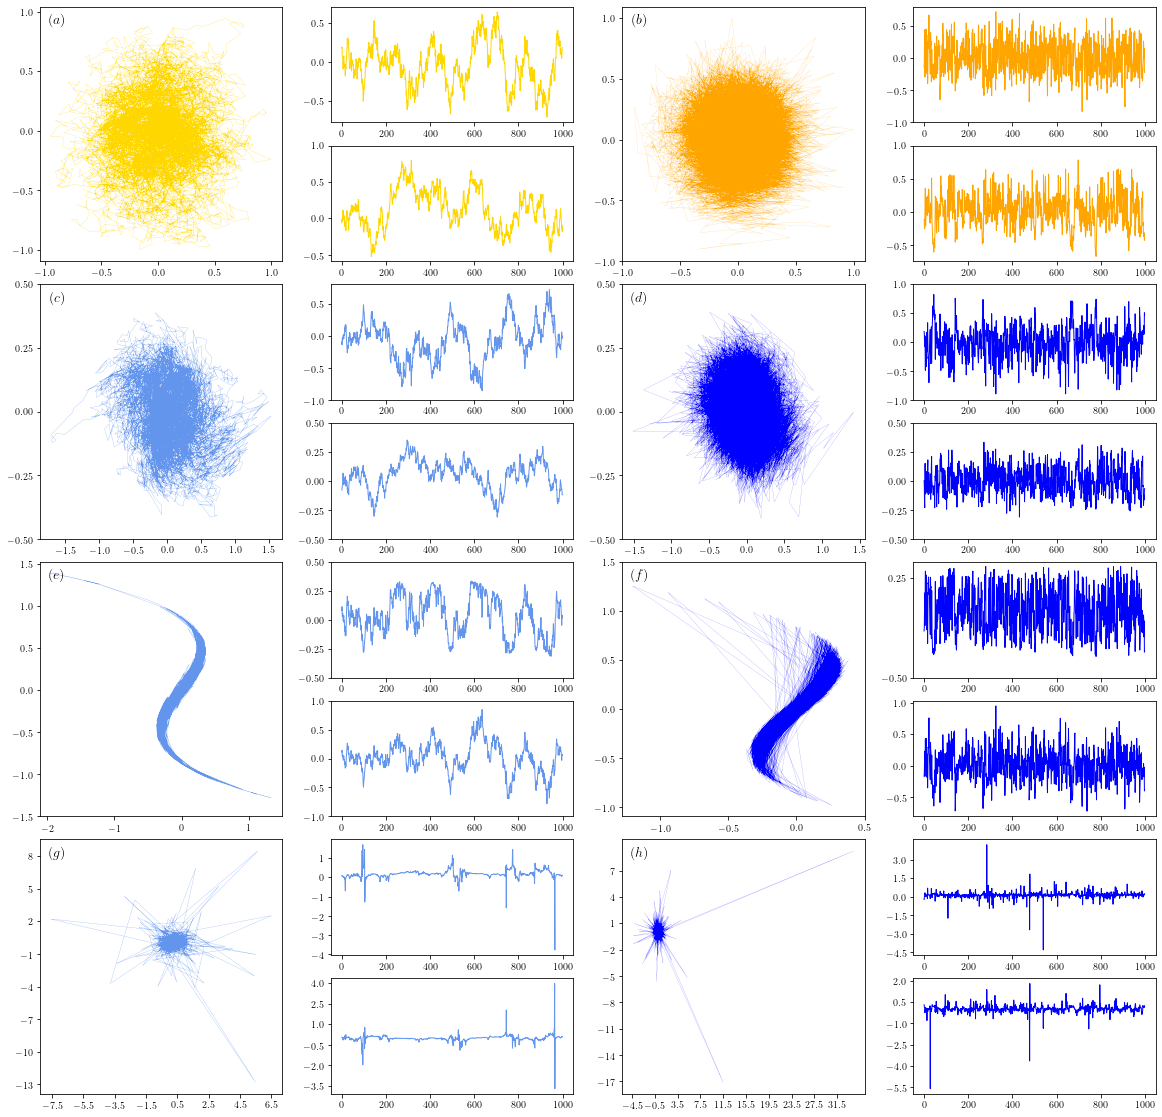

In [65]:
'''Planar Mixtures for Experiment I -- Plotted'''

import matplotlib.gridspec as gridspec
gs        = gridspec.GridSpec(4*2, 4)
n_scatter = 10000
n_paths   = 1000

plt.figure(figsize=(20, 4*5)) 
ax        = plt.subplot(gs[0:2,0])
plt.plot(S1ou[:n_scatter], S2ou[:n_scatter], linewidth=0.2, color='gold', rasterized=True)
plt.xticks(np.arange(round(np.min(S1ou[:n_scatter])*2)/2, round(np.max(S1ou[:n_scatter])*2)/2+0.1, step=0.5))
plt.yticks(np.arange(round(np.min(S2ou[:n_scatter])*2)/2, round(np.max(S2ou[:n_scatter])*2)/2+0.1, step=0.5))
plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
plt.title(r'')

ax        = plt.subplot(gs[0,1])
plt.plot(S1ou[:n_paths], linewidth=1, color='gold', rasterized=True)
plt.yticks(np.arange(round(np.min(S1ou[:n_paths])*2)/2, round(np.max(S1ou[:n_paths])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[1,1])
plt.plot(S2ou[:n_paths], linewidth=1, color='gold', rasterized=True)
plt.yticks(np.arange(round(np.min(S2ou[:n_paths])*2)/2, round(np.max(S2ou[:n_paths])*2)/2+0.1, step=0.5))
plt.title(r'')
############################################################################################
ax        = plt.subplot(gs[0:2,2])
plt.plot(S1cy[:n_scatter], S2cy[:n_scatter], linewidth=0.1, color='orange', rasterized=True)
plt.xticks(np.arange(round(np.min(S1cy[:n_scatter])*2)/2, round(np.max(S1cy[:n_scatter])*2)/2+0.1, step=0.5))
plt.yticks(np.arange(round(np.min(S2cy[:n_scatter])*2)/2, round(np.max(S2cy[:n_scatter])*2)/2+0.1, step=0.5))
plt.text(0.075, 0.945,'$(b)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
plt.title(r'')

ax        = plt.subplot(gs[0,3])
plt.plot(S1cy[:n_paths], linewidth=1, color='orange', rasterized=True)
plt.yticks(np.arange(round(np.min(S1cy[:n_paths])*2)/2, round(np.max(S1cy[:n_paths])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[1,3])
plt.plot(S2cy[:n_paths], linewidth=1, color='orange', rasterized=True)
plt.yticks(np.arange(round(np.min(S2cy[:n_paths])*2)/2, round(np.max(S2cy[:n_paths])*2)/2+0.1, step=0.5))
plt.title(r'')

######################################### Mixing 1 #########################################
############################################################################################
i = 1
ax        = plt.subplot(gs[2+2*(i-1):2+2*i,0])
plt.plot(Xou_1[:n_scatter,0], Xou_1[:n_scatter,1], linewidth=0.2, color='cornflowerblue', rasterized=True)
plt.xticks(np.arange(round(np.min(Xou_1[:n_scatter,0])*2)/2, round(np.max(Xou_1[:n_scatter,0])*2)/2+0.1, step=0.5))
plt.yticks(np.arange(round(np.min(Xou_1[:n_scatter,1])*2)/2, round(np.max(Xou_1[:n_scatter,1])*2)/2+0.1, step=0.25))
plt.text(0.075, 0.945,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1),1])
plt.plot(Xou_1[:n_paths,0], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_1[:n_paths,0])*2)/2, round(np.max(Xou_1[:n_paths,0])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1)+1,1])
plt.plot(Xou_1[:n_paths,1], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_1[:n_paths,1])*2)/2, round(np.max(Xou_1[:n_paths,1])*2)/2+0.1, step=0.25))
plt.title(r'')
############################################################################################
ax        = plt.subplot(gs[2+2*(i-1):2+2*i,2])
plt.plot(Xcy_1[:n_scatter,0], Xcy_1[:n_scatter,1], linewidth=0.1, color='blue', rasterized=True)
plt.xticks(np.arange(round(np.min(Xcy_1[:n_scatter,0])*2)/2, round(np.max(Xcy_1[:n_scatter,0])*2)/2+0.1, step=0.5))
plt.yticks(np.arange(round(np.min(Xcy_1[:n_scatter,1])*2)/2, round(np.max(Xcy_1[:n_scatter,1])*2)/2+0.1, step=0.25))
plt.text(0.075, 0.945,'$(d)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1),3])
plt.plot(Xcy_1[:n_paths,0], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_1[:n_paths,0])*2)/2, round(np.max(Xcy_1[:n_paths,0])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1)+1,3])
plt.plot(Xcy_1[:n_paths,1], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_1[:n_paths,1])*2)/2, round(np.max(Xcy_1[:n_paths,1])*2)/2+0.1, step=0.25))
plt.title(r'')

######################################### Mixing 2 #########################################
############################################################################################
i = 2
ax        = plt.subplot(gs[2+2*(i-1):2+2*i,0])
plt.plot(Xou_2[:n_scatter,0], Xou_2[:n_scatter,1], linewidth=0.2, color='cornflowerblue', rasterized=True)
plt.xticks(np.arange(round(np.min(Xou_2[:n_scatter,0])*2)/2, round(np.max(Xou_2[:n_scatter,0])*2)/2+0.1, step=1))
plt.yticks(np.arange(round(np.min(Xou_2[:n_scatter,1])*2)/2, round(np.max(Xou_2[:n_scatter,1])*2)/2+0.1, step=0.5))
plt.text(0.075, 0.945,'$(e)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1),1])
plt.plot(Xou_2[:n_paths,0], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_2[:n_paths,0])*2)/2, round(np.max(Xou_2[:n_paths,0])*2)/2+0.1, step=0.25))
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1)+1,1])
plt.plot(Xou_2[:n_paths,1], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_2[:n_paths,1])*2)/2, round(np.max(Xou_2[:n_paths,1])*2)/2+0.1, step=0.5))
plt.title(r'')
############################################################################################
ax        = plt.subplot(gs[2+2*(i-1):2+2*i,2])
plt.plot(Xcy_2[:n_scatter,0], Xcy_2[:n_scatter,1], linewidth=0.1, color='blue', rasterized=True)
plt.xticks(np.arange(round(np.min(Xcy_2[:n_scatter,0])*2)/2, round(np.max(Xcy_2[:n_scatter,0])*2)/2+0.1, step=0.5))
plt.yticks(np.arange(round(np.min(Xcy_2[:n_scatter,1])*2)/2, round(np.max(Xcy_2[:n_scatter,1])*2)/2+0.1, step=0.5))
plt.text(0.075, 0.945,'$(f)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1),3])
plt.plot(Xcy_2[:n_paths,0], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_2[:n_paths,0])*2)/2, round(np.max(Xcy_2[:n_paths,0])*2)/2+0.1, step=0.75))
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1)+1,3])
plt.plot(Xcy_2[:n_paths,1], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_2[:n_paths,1])*2)/2, round(np.max(Xcy_2[:n_paths,1])*2)/2+0.1, step=0.5))
plt.title(r'')

######################################### Mixing 3 #########################################
############################################################################################
i = 3
ax        = plt.subplot(gs[2+2*(i-1):2+2*i,0])
plt.plot(Xou_3[:n_scatter,0], Xou_3[:n_scatter,1], linewidth=0.2, color='cornflowerblue', rasterized=True)
plt.xticks(np.arange(round(np.min(Xou_3[:n_scatter,0])*2)/2, round(np.max(Xou_3[:n_scatter,0])*2)/2+0.1, step=2))
plt.yticks(np.arange(round(np.min(Xou_3[:n_scatter,1])*2)/2, round(np.max(Xou_3[:n_scatter,1])*2)/2+0.1, step=3))
plt.text(0.075, 0.945,'$(g)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1),1])
plt.plot(Xou_3[:n_paths,0], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_3[:n_paths,0])*2)/2, round(np.max(Xou_3[:n_paths,0])*2)/2+0.1, step=1))
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1)+1,1])
plt.plot(Xou_3[:n_paths,1], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_3[:n_paths,1])*2)/2, round(np.max(Xou_3[:n_paths,1])*2)/2+0.1, step=1.5))
plt.title(r'')
############################################################################################
ax        = plt.subplot(gs[2+2*(i-1):2+2*i,2])
plt.plot(Xcy_3[:n_scatter,0], Xcy_3[:n_scatter,1], linewidth=0.1, color='blue', rasterized=True)
plt.xticks(np.arange(round(np.min(Xcy_3[:n_scatter,0])*2)/2, round(np.max(Xcy_3[:n_scatter,0])*2)/2+0.1, step=4))
plt.yticks(np.arange(round(np.min(Xcy_3[:n_scatter,1])*2)/2, round(np.max(Xcy_3[:n_scatter,1])*2)/2+0.1, step=3))
plt.text(0.075, 0.945,'$(h)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1),3])
plt.plot(Xcy_3[:n_paths,0], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_3[:n_paths,0])*2)/2, round(np.max(Xcy_3[:n_paths,0])*2)/2+0.1, step=1.5))
plt.title(r'')

ax        = plt.subplot(gs[2+2*(i-1)+1,3])
plt.plot(Xcy_3[:n_paths,1], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_3[:n_paths,1])*2)/2, round(np.max(Xcy_3[:n_paths,1])*2)/2+0.1, step=1.5))
plt.title(r'')

#plt.savefig('PlanarTableau.pdf', dpi=300)

Text(0.5, 1.0, '')

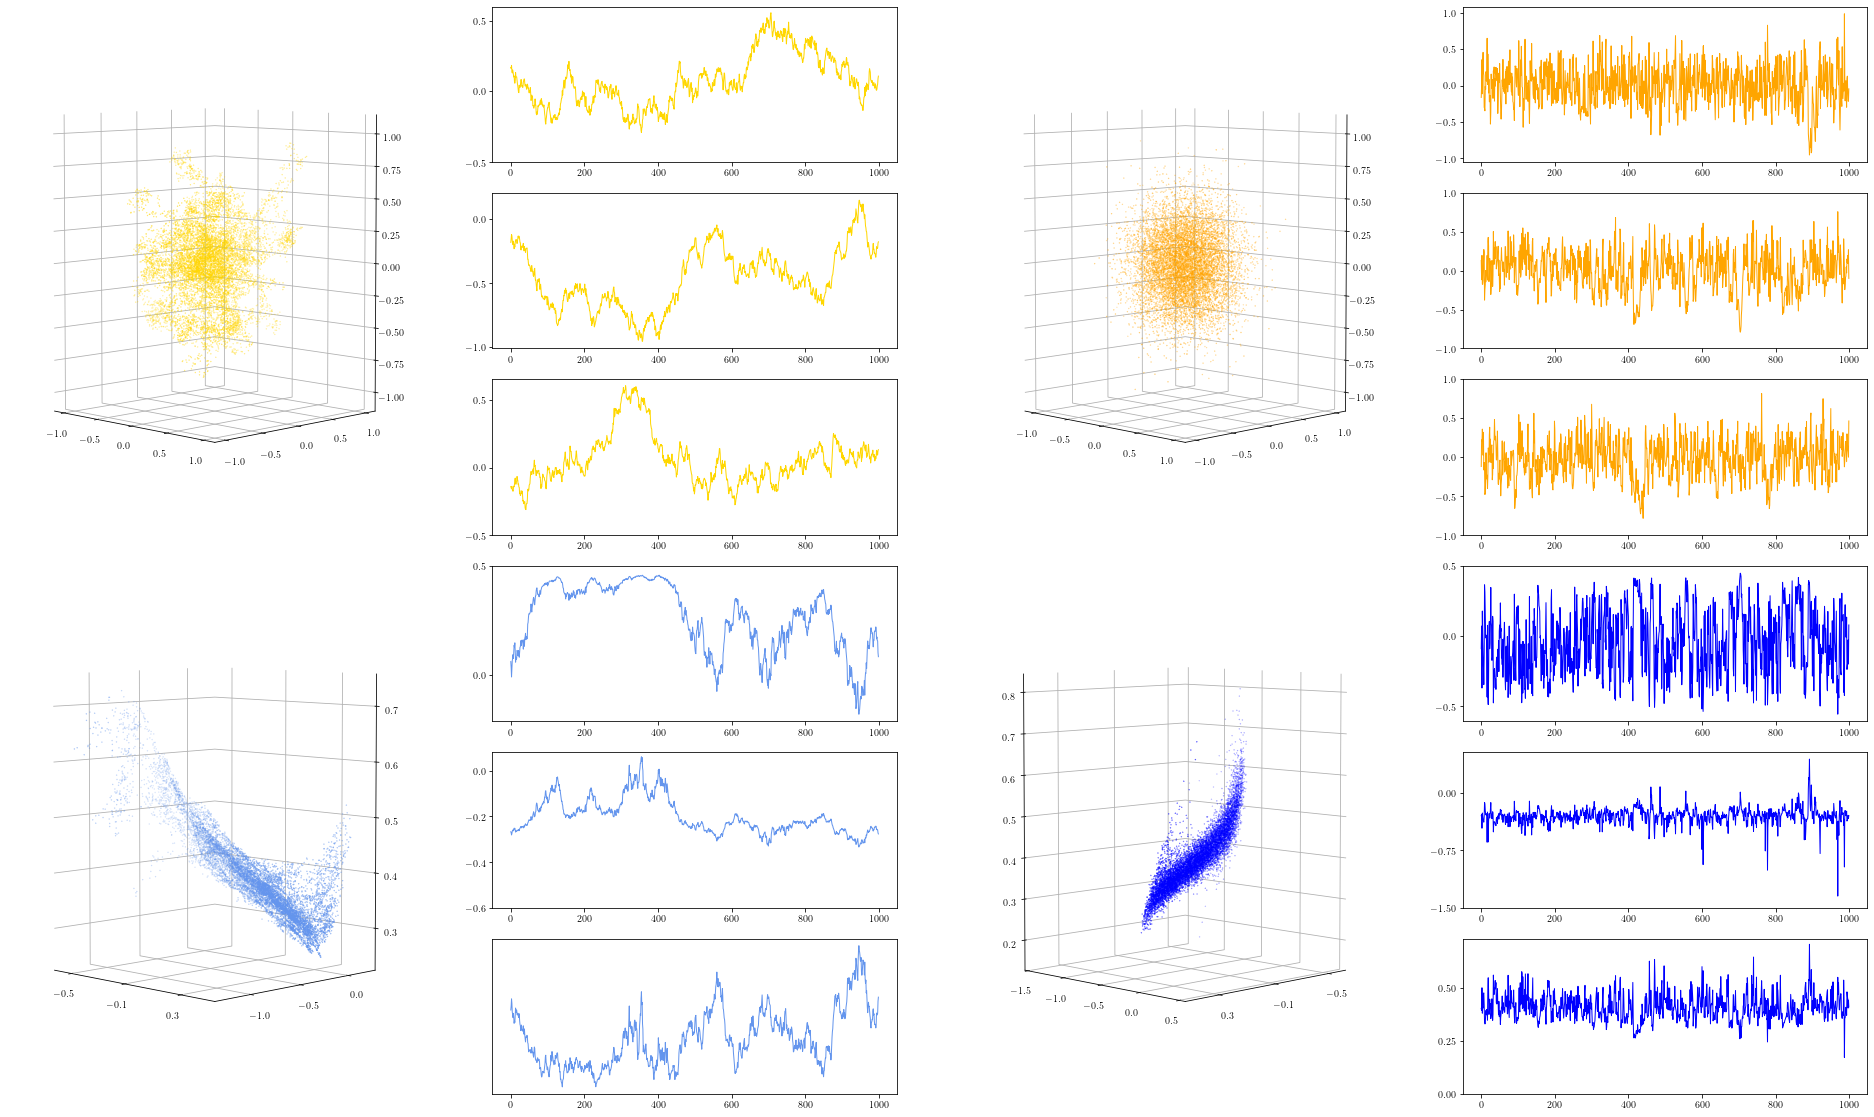

In [75]:
'''3D-Mixture for Experiment I -- Plotted'''

gs        = gridspec.GridSpec(6, 4)

n_scatter = 10000
n_paths   = 1000

plt.figure(figsize=plt.figaspect(0.6)*5)

ax1 = plt.axes(projection="3d")
scaling = np.array([getattr(ax1, 'get_{}lim'.format(dim))() for dim in 'xyz'])
ax1.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)

#########################################  Sources  ########################################
############################################################################################

ax        = plt.subplot(gs[0:3,0], projection='3d')
ax.scatter(S3D_ou[:n_scatter,0],S3D_ou[:n_scatter,1],S3D_ou[:n_scatter,2], s=0.1, color='gold', rasterized=True)
ax.auto_scale_xyz([-1,1],[-1,1],[-1,1])
plt.xticks(np.arange(-1, 1.1, step=0.5))
plt.yticks(np.arange(-1, 1.1, step=0.5))
#plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=5, azim=-45)
plt.title(r'')

ax        = plt.subplot(gs[0,1])
plt.plot(S3D_ou[:n_paths,0], linewidth=1, color='gold', rasterized=True)
plt.yticks(np.arange(round(np.min(S3D_ou[:n_paths,0])*2)/2, round(np.max(S3D_ou[:n_paths,0])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[1,1])
plt.plot(S3D_ou[:n_paths,1], linewidth=1, color='gold', rasterized=True)
plt.yticks(np.arange(round(np.min(S3D_ou[:n_paths,1])*2)/2, round(np.max(S3D_ou[:n_paths,1])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[2,1])
plt.plot(S3D_ou[:n_paths,2], linewidth=1, color='gold', rasterized=True)
plt.yticks(np.arange(round(np.min(S3D_ou[:n_paths,2])*2)/2, round(np.max(S3D_ou[:n_paths,2])*2)/2+0.1, step=0.5))
plt.title(r'')
############################################################################################
ax        = plt.subplot(gs[0:3,2],projection='3d')
ax.scatter(S3D_cy[:n_scatter,0],S3D_cy[:n_scatter,1],S3D_cy[:n_scatter,2], s=0.1, color='orange', rasterized=True)
ax.auto_scale_xyz([-1,1],[-1,1],[-1,1])
plt.xticks(np.arange(-1, 1.1, step=0.5))
plt.yticks(np.arange(-1, 1.1, step=0.5))
#plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=5, azim=-45)
plt.title(r'')

ax        = plt.subplot(gs[0,3])
plt.plot(S3D_cy[:n_paths,0], linewidth=1, color='orange', rasterized=True)
plt.yticks(np.arange(round(np.min(S3D_cy[:n_paths,0])*2)/2, round(np.max(S3D_cy[:n_paths,0])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[1,3])
plt.plot(S3D_cy[:n_paths,1], linewidth=1, color='orange', rasterized=True)
plt.yticks(np.arange(round(np.min(S3D_cy[:n_paths,1])*2)/2, round(np.max(S3D_cy[:n_paths,1])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[2,3])
plt.plot(S3D_cy[:n_paths,2], linewidth=1, color='orange', rasterized=True)
plt.yticks(np.arange(round(np.min(S3D_cy[:n_paths,2])*2)/2, round(np.max(S3D_cy[:n_paths,2])*2)/2+0.1, step=0.5))
plt.title(r'')

#########################################  Mixing  #########################################
############################################################################################

i = 1
ax        = plt.subplot(gs[3+3*(i-1):3+3*i,0], projection='3d')
ax.scatter(Xou_4[:n_scatter,0],Xou_4[:n_scatter,1],Xou_4[:n_scatter,2], s=0.1, color='cornflowerblue', rasterized=True)
scaling = np.array([getattr(ax1, 'get_{}lim'.format(dim))() for dim in 'xyz'])
ax1.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)
plt.xticks(np.arange(round(np.min(Xou_4[:n_scatter,0])*2)/2, round(np.max(Xou_4[:n_scatter,0])*2)/2+0.1, step=0.4))
plt.yticks(np.arange(round(np.min(Xou_4[:n_scatter,1])*2)/2, round(np.max(Xou_4[:n_scatter,1])*2)/2+0.1, step=0.5))
#plt.text(0.075, 0.945,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=5, azim=-45)
plt.title(r'')

ax        = plt.subplot(gs[3+3*(i-1),1])
plt.plot(Xou_4[:n_paths,0], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_4[:n_paths,0])*2)/2, round(np.max(Xou_4[:n_paths,0])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[3+3*(i-1)+1,1])
plt.plot(Xou_4[:n_paths,1], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_4[:n_paths,1])*2)/2-0.1, round(np.max(Xou_4[:n_paths,1])*2)/2+0.2, step=0.2))
plt.title(r'')

ax        = plt.subplot(gs[3+3*(i-1)+2,1])
plt.plot(Xou_4[:n_paths,2], linewidth=1, color='cornflowerblue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xou_4[:n_paths,2])*2)/2, round(np.max(Xou_4[:n_paths,2])*2)/2+0.1, step=0.25))
plt.title(r'')
############################################################################################
ax        = plt.subplot(gs[3+3*(i-1):3+3*i,2], projection='3d')
ax.scatter(Xcy_4[:n_scatter,0],Xcy_4[:n_scatter,1],Xcy_4[:n_scatter,2], s=0.1, color='blue', rasterized=True)
scaling = np.array([getattr(ax1, 'get_{}lim'.format(dim))() for dim in 'xyz'])
ax1.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)
plt.xticks(np.arange(round(np.min(Xcy_4[:n_scatter,0])*2)/2, round(np.max(Xcy_4[:n_scatter,0])*2)/2+0.1, step=0.4))
plt.yticks(np.arange(round(np.min(Xcy_4[:n_scatter,1])*2)/2, round(np.max(Xcy_4[:n_scatter,1])*2)/2+0.1, step=0.5))
#plt.text(0.075, 0.945,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=5, azim=45) ###########################################################    ############ 
plt.title(r'')

ax        = plt.subplot(gs[3+3*(i-1),3])
plt.plot(Xcy_4[:n_paths,0], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_4[:n_paths,0])*2)/2, round(np.max(Xcy_4[:n_paths,0])*2)/2+0.1, step=0.5))
plt.title(r'')

ax        = plt.subplot(gs[3+3*(i-1)+1,3])
plt.plot(Xcy_4[:n_paths,1], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_4[:n_paths,1])*2)/2, round(np.max(Xcy_4[:n_paths,1])*2)/2+0.1, step=0.75))
plt.title(r'')

ax        = plt.subplot(gs[3+3*(i-1)+2,3])
plt.plot(Xcy_4[:n_paths,2], linewidth=1, color='blue', rasterized=True)
plt.yticks(np.arange(round(np.min(Xcy_4[:n_paths,2])*2)/2, round(np.max(Xcy_4[:n_paths,2])*2)/2+0.1, step=0.25))
plt.title(r'')

#plt.savefig('3DTableau.pdf', dpi=300)

## Choice of Parametrizations for Candidate Demixing-Functions

The advantage of the mixing transforms $f_j$ is that their inverses $g_j:=f_j^{-1}$ are explicitly known and can each be easily associated to a continuosly parametrized family $\Theta_j$ of $C^{3,3}$-invertible transformations on $\mathbb{R}^2$ resp. $\mathbb{R}^3$. Reasonably large choices for such families are given below.

\begin{align}\label{experI:eq8}\tag{8}
g_1 &= g_{(1,0.5)}^{(1)} \quad&&\text{for}\quad \left\{g_{(\theta_1,\theta_2)}^{(1)}:= h_{(0,\theta_1)}\circ A^\intercal\circ h^{-1}_{(0,\theta_2)} \ \middle| \ (\theta_1, \theta_2) \in (-1,1)\times(-1,1.5)=:\tilde{\Theta}_1\right\}=:\Theta_1 \\
g_2 &= g_{(-0.35,1)}^{(2)} \quad&&\text{for}\quad \left\{g_{(\theta_1,\theta_2)}^{(2)}:= A_2^{-1}\circ\varphi^{-1}_{(0,1)}\circ\big(h^{-1}_{(0,0.5)}\circ h_{(0,\theta_1)}\big)\circ\varphi_{(0,\theta_2)} \ \middle| \ (\theta_1, \theta_2) \in (-0.8,0.02)\times(0.8,1.2)=:\tilde{\Theta}_2\right\}=:\Theta_2 \label{experI:eq9}\tag{9} \\
g_3 &= g_{(1,-2)}^{(3)} \quad&&\text{for}\quad \left\{g_{(\theta_1,\theta_2)}^{(3)}:= m_{(1,0,\theta_2,1)}\circ A^\intercal\circ m_{(\theta_1,0,2,1)}^{-1} \ \middle| \ (\theta_1, \theta_2) \in (-2,2)\times(-3,1)=:\tilde{\Theta}_3\right\}=:\Theta_3  \label{experI:eq10}\tag{10}\\
g_4 &= g_{(0.2,-5)}^{(4)} \quad&&\text{for}\quad \left\{g_{(\theta_1,\theta_2)}^{(4)}:= \big(A_4^{(1)}\big)^{-1}\circ\beta_{(\theta_1,\theta_2)}\circ\big(A_4^{(2)}\big)^{-1} \ \middle| \ (\theta_1, \theta_2) \in (-1.1,2)\times(-8.2,-2.2)=:\tilde{\Theta}_4\right\}=:\Theta_4,  \label{experI:eq11}\tag{11}\\
\end{align}

where in the second line we set $\varphi_{(\theta_1,\theta_2)}(x):=A_2\circ h^{-1}_{(\theta_1,\theta_2)}$ and for the last line defined $\beta_{(\theta_1,\theta_2)}(x):=\big(\log(100\cdot x_3), \ (-x_1/\theta_1)^{1/3}, \ \mathrm{arctan}(100\cdot x_2)/\theta_2\big)^\intercal$. 

We are interested in (by way of their plots) comparing the topography of the monomial discordances

\begin{equation}\label{experI:eq12}\tag{12}
\delta_\eta^j \ : \ \tilde{\Theta}_j \ \ni \theta \quad \longmapsto \quad \varrho(g^{(j)}_\theta\cdot X^{(j)}_\eta,\, S_\eta) \ \in \ \mathbb{R}_+
\end{equation}

to that of the contrast functions 

\begin{equation}\label{experI:eq13}\tag{13}
\Phi_\eta^j \ : \ \tilde{\Theta}_j \ \ni \theta \quad \longmapsto \quad \phi_{\hat{\mu}}(g^{(j)}_\theta\cdot X^{(j)}_\eta) \ \in \ \mathbb{R}_+
\end{equation}

with $\phi_{\hat{\mu}}(Y)$ the signature-cumulant series of $Y$ truncated at the order $\hat{\mu}$ (cf. the paper). To this end, we grid the parameter domains $\tilde{\Theta}_j$ as follows.

In [144]:
'''Grids for \tilde{\Theta}_j:'''

from collections import namedtuple
Theta = namedtuple('Theta', 'x1 y1 x2 y2 x3 y3 x4 y4') # store the different parameter domains as named tuples (cf. [2])

# Parameters for Mixing 1:
Th1_x  = np.arange(-1, 1.05, 0.1)
Th1_y  = np.arange(-1, 1.55, 0.1)  

# Parameters for Mixing 2:
Th2_x = np.arange(-0.8, 0.02, 0.05) 
Th2_y = np.arange(0.8, 1.2, 0.02)   

# Parameter domain for Mixing 3:
Th3_x  = np.arange(-2.1, 2.01, 0.1)
Th3_y  = np.arange(-3, 1.01, 0.1)   

# Parameter domain for Mixing 4:
Th4_x  = np.arange(-1.1, 2.01, 0.15)
Th4_y  = np.arange(-8.2, -2.2, 0.2)   

theta  = Theta(Th1_x, Th1_y, Th2_x, Th2_y, Th3_x, Th3_y, Th4_x, Th4_y)

# References:
# [2] : https://stackoverflow.com/questions/21469359/dynamic-variable-names-from-a-list-of-strings-in-python

The above parametrizations (8) -- (11) are implemented as follows.

In [8]:
'''Implementation of \Theta_j:'''

# Theta_1 (8):
def inv_aux(x,B,theta):
    
    y1 = HenonX3Inv(x, np.asarray([0,theta[1]]))
    y2 = LinTrafo(B.T,y1)
    y3 = HenonX3(y2, np.asarray([0,theta[0]]))
    
    return y3

def g_1(x,theta):
    
    return inv_aux(x,A,theta)

# Theta_2 (9):
def g_2(x,theta):
    
    y1 = inv_aux(x,A.T,theta)
    y2 = inv_aux(y1, A, np.asarray([1,0.5]))
    y3 = LinTrafo(B2,y2)
    
    return y3

# Theta_3 (10):
def g_3(x,theta):
 
    y1 = moebInv(x,np.asarray([theta[0],0,2,1]))
    y2 = LinTrafo(A3.T, y1)
    y3 = moeb(y2, np.asarray([1,0,theta[1],1]))
    
    return y3

# Theta_4 (11):
def g_4(x,theta):

    y1 = linmap(A_42inv,x)
    y2 = middlemapInv(y1,theta)
    y3 = linmap(A_41inv,y2)
    
    return y3


## Plotting the Functions ([12](#mjx-eqn-experI:eq12)) and ([13](#mjx-eqn-experI:eq13))

The functions ([12](#mjx-eqn-experI:eq12)) and ([13](#mjx-eqn-experI:eq13)) are plotted using their respective Python implementations $\texttt{mondis.MonomialDiscordance}()$ and $\texttt{sigic.SigCF}()$. 

The function below computes the monomial discordance $\delta(g_\theta(X),S)$ of ([12](#mjx-eqn-experI:eq12)) over given grids of the above parameter domains $\Theta_j$. 

In [167]:
'''Monomial Discordance'''

def delta(X_in, S_in, batchlen, Theta_x, Theta_y, s):
    '''Input: observable X_in and source process S_in [both (n,d)-arrays], batch-length batchlen [int], 
              param. domain Theta = (Theta_x)x(Theta_y) [both Theta_x and Theta_y are (k,)-arrays],
              number j of the mixing considered [string, j='1','2','3','4']
       Output: profile of monomial discordance delta(X_in, S_in, batchlen) over Theta_x\timesTheta_y'''
    delta_Theta = np.zeros((len(Theta_x),len(Theta_y)))
    # Check which mixing case is given:
    if s=='1':
        for i in range(len(Theta_x)):
            for j in range(len(Theta_y)):
                X_theta          = g_1(X_in, np.asarray([Theta_x[i],Theta_y[j]]))
                delta_Theta[i,j] = mondis.MonomialDiscordance(X_theta, S_in, batchlen, 'kendall')
                print('s = ',((i+1)*len(Theta_x)+(j+1))/(len(Theta_x)*len(Theta_y)), end="\r") #print progress
                time.sleep(0.1)
    elif s=='2':
        for i in range(len(Theta_x)):
            for j in range(len(Theta_y)):
                X_theta          = g_2(X_in, np.asarray([Theta_x[i],Theta_y[j]]))
                delta_Theta[i,j] = mondis.MonomialDiscordance(X_theta, S_in, batchlen, 'kendall')
                print('s = ',((i+1)*len(Theta_x)+(j+1))/(len(Theta_x)*len(Theta_y)), end="\r")
                time.sleep(0.1)
    elif s=='3':
        for i in range(len(Theta_x)):
            for j in range(len(Theta_y)):
                X_theta          = g_3(X_in, np.asarray([Theta_x[i],Theta_y[j]]))
                delta_Theta[i,j] = mondis.MonomialDiscordance(X_theta, S_in, batchlen, 'kendall')
                print('s = ',((i+1)*len(Theta_x)+(j+1))/(len(Theta_x)*len(Theta_y)), end="\r")
                time.sleep(0.1)
    else:
        for i in range(len(Theta_x)):
            for j in range(len(Theta_y)):
                X_theta          = g_4(X_in, np.asarray([Theta_x[i],Theta_y[j]]))
                delta_Theta[i,j] = mondis.MonomialDiscordance(X_theta, S_in, batchlen, 'kendall')
                print('s = ',((i+1)*len(Theta_x)+(j+1))/(len(Theta_x)*len(Theta_y)), end="\r")
                time.sleep(0.1)
                
    return delta_Theta


The following function computes the contrast function $\phi_{\hat{\mu}}(g_\theta(X),S)$ of ([13](#mjx-eqn-experI:eq13)) over given grids of the above parameter domains $\Theta_j$. 

In [168]:
'''Contrast Function (Signature-Cross-Cumulants)'''

def Phi_SigIC(X_in, mu, batchlen, Theta_x, Theta_y, s):
    '''Input: observable X_in [(n,d)-array], control-tuple mu [(d-1,)-array], batch-length [=#samples per sig. computation] 
              batchlen [int], param. domain Theta = (Theta_x)x(Theta_y) [both Theta_x and Theta_y are (k,)-arrays],
              number j of the mixing considered [str, j='1','2','3','4']
       Output: contrast profile Phi_SigIC(Theta) [(k,k)-array]'''
    Phi_Theta = torch.zeros((len(Theta_x),len(Theta_y)))
    # Check which mixing case is given:
    if s=='1':
        for i in range(len(Theta_x)):
            for j in range(len(Theta_y)):
                X_theta        = torch.from_numpy(g_1(X_in.numpy(), np.asarray([Theta_x[i],Theta_y[j]])))
                Phi_Theta[i,j] = sigic.SigCF(X_theta, mu, batchlen).item()
                print('s = ',((i+1)*len(Theta_x)+(j+1))/(len(Theta_x)*len(Theta_y)), end="\r") #print progress
                time.sleep(0.1)
               
    elif s=='2':
        for i in range(len(Theta_x)):
            for j in range(len(Theta_y)):
                X_theta        = torch.from_numpy(g_2(X_in.numpy(), np.asarray([Theta_x[i],Theta_y[j]])))
                Phi_Theta[i,j] = sigic.SigCF(X_theta, mu, batchlen).item()
                print('s = ',((i+1)*len(Theta_x)+(j+1))/(len(Theta_x)*len(Theta_y)), end="\r")
                time.sleep(0.1)
    elif s=='3':
        for i in range(len(Theta_x)):
            for j in range(len(Theta_y)):
                X_theta        = torch.from_numpy(g_3(X_in.numpy(), np.asarray([Theta_x[i],Theta_y[j]])))
                X_theta2        = sigic.rem_outls(X_theta,np.asarray([0.03,0.03])) # remove most severe outliers
                Phi_Theta[i,j] = sigic.SigCF(X_theta2, mu, batchlen).item()
                print('s = ',((i+1)*len(Theta_x)+(j+1))/(len(Theta_x)*len(Theta_y)), end="\r")
                time.sleep(0.1)
    else:
        for i in range(len(Theta_x)):
            for j in range(len(Theta_y)):
                X_theta        = torch.from_numpy(g_4(X_in.numpy(), np.asarray([Theta_x[i],Theta_y[j]])))
                X_theta2        = sigic.rem_outls(X_theta,np.asarray([0.03,0.03,0.03])) # remove most severe outliers
                Phi_Theta[i,j] = sigic.SigCF(X_theta2, mu, batchlen).item()
                print('s = ',((i+1)*len(Theta_x)+(j+1))/(len(Theta_x)*len(Theta_y)), end="\r")
                time.sleep(0.1)
    
    return Phi_Theta


### Collect Results

Generate plots of ([12](#mjx-eqn-experI:eq12)) over ([8](#mjx-eqn-experI:eq8)), ([9](#mjx-eqn-experI:eq9)), ([10](#mjx-eqn-experI:eq10)), ([11](#mjx-eqn-experI:eq11)).

In [ ]:
bl         = 100 # batchlength for estimation of mon.discordance

'''(j,eta) = (1,cy):'''
delta_1cy  = delta(Xcy_1,S_cy,bl,theta.x1,theta.y1,'1')
'''(j,eta) = (1,ou):'''
delta_1ou  = delta(Xou_1,S_ou,bl,theta.x1,theta.y1,'1')

'''(j,eta) = (2,cy):'''
delta_2cy  = delta(Xcy_2,S_cy,bl,theta.x2,theta.y2,'2')
'''(j,eta) = (2,ou):'''
delta_2ou  = delta(Xou_2,S_ou,bl,theta.x2,theta.y2,'2')

'''(j,eta) = (3,cy):'''
delta_3cy  = delta(Xcy_3,S_cy,bl,theta.x3,theta.y3,'3')
'''(i,eta) = (3,ou):'''
delta_3ou  = delta(Xou_3,S_ou,bl,theta.x3,theta.y3,'3')

'''(j,eta) = (4,cy):'''
delta_4cy  = delta(Xcy_4,S_cy,bl,theta.x4,theta.y4,'4')
'''(i,eta) = (4,ou):'''
delta_4ou  = delta(Xou_4,S_ou,bl,theta.x4,theta.y4,'4')


Generate plots of ([13](#mjx-eqn-experI:eq13)) over ([8](#mjx-eqn-experI:eq8)), ([9](#mjx-eqn-experI:eq9)), ([10](#mjx-eqn-experI:eq10)), ([11](#mjx-eqn-experI:eq11)).

In [188]:
# choose parameters for (13) (cf. SigContrast.ipynb)
batchl      = 100             # length of data points per signature-sample 
mu          = np.asarray([6]) # control tuple

'''(j,eta) = (1,cy):'''
phi_1cy    = Phi_SigIC(torch.from_numpy(Xcy_1),mu,batchl,theta.x1,theta.y1,'1')
'''(j,eta) = (1,ou):'''
phi_1ou    = Phi_SigIC(torch.from_numpy(Xou_1),mu,batchl,theta.x1,theta.y1,'1')

'''(j,eta) = (2,cy):'''
phi_2cy    = Phi_SigIC(torch.from_numpy(Xcy_2),mu,batchl/10,theta.x2,theta.y2,'2')
'''(j,eta) = (2,ou):'''
phi_2ou    = Phi_SigIC(torch.from_numpy(Xou_2),mu,batchl,theta.x2,theta.y2,'2')

'''(j,eta) = (3,cy):'''
phi_3cy    = Phi_SigIC(torch.from_numpy(Xcy_3),mu,batchl,theta.x3,theta.y3,'3')
'''(j,eta) = (3,ou):'''
phi_3ou    = Phi_SigIC(torch.from_numpy(Xou_3),mu,batchl,theta.x3,theta.y3,'3')

'''(j,eta) = (4,cy):'''
phi_4cy    = Phi_SigIC(torch.from_numpy(Xcy_4),np.asarray([7,7]),10,theta.x4,theta.y4,'4')
'''(j,eta) = (4,ou):'''
phi_4ou    = Phi_SigIC(torch.from_numpy(Xou_4),np.asarray([7,7]),10,theta.x4,theta.y4,'4')


For convenience, the results of these computations are imported below.

In [189]:
import os
current_directory = os.getcwd()
import pickle

# Monomial Discordances over \Theta_j (j=1,2,3,4):
with open(current_directory+'\\Simulation_Results\delta_1cy.pickle', 'rb') as handle:
    delta_1cy = pickle.load(handle)
with open(current_directory+'\\Simulation_Results\delta_1ou.pickle', 'rb') as handle:
    delta_1ou = pickle.load(handle)
    
with open(current_directory+'\\Simulation_Results\delta_2cy.pickle', 'rb') as handle:
    delta_2cy = pickle.load(handle)
with open(current_directory+'\\Simulation_Results\delta_2ou.pickle', 'rb') as handle:
    delta_2ou = pickle.load(handle)    
    
with open(current_directory+'\\Simulation_Results\delta_3cy.pickle', 'rb') as handle:
    delta_3cy = pickle.load(handle)
with open(current_directory+'\\Simulation_Results\delta_3ou.pickle', 'rb') as handle:
    delta_3ou = pickle.load(handle)  
    
with open(current_directory+'\\Simulation_Results\delta_4cy.pickle', 'rb') as handle:
    delta_4cy = pickle.load(handle)
with open(current_directory+'\\Simulation_Results\delta_4ou.pickle', 'rb') as handle:
    delta_4ou = pickle.load(handle)    
    
# Signature Contrast over \Theta_j (j=1,2,3,4):
with open(current_directory+'\\Simulation_Results\phi_1cy.pickle', 'rb') as handle:
    phi_1cy = pickle.load(handle)
with open(current_directory+'\\Simulation_Results\phi_1ou.pickle', 'rb') as handle:
    phi_1ou = pickle.load(handle)
    
with open(current_directory+'\\Simulation_Results\phi_2cy.pickle', 'rb') as handle:
    phi_2cy = pickle.load(handle)
with open(current_directory+'\\Simulation_Results\phi_2ou.pickle', 'rb') as handle:
    phi_2ou = pickle.load(handle)    
    
with open(current_directory+'\\Simulation_Results\phi_3cy.pickle', 'rb') as handle:
    phi_3cy = pickle.load(handle)
with open(current_directory+'\\Simulation_Results\phi_3ou.pickle', 'rb') as handle:
    phi_3ou = pickle.load(handle)  
    
with open(current_directory+'\\Simulation_Results\phi_4cy.pickle', 'rb') as handle:
    phi_4cy = pickle.load(handle)
with open(current_directory+'\\Simulation_Results\phi_4ou.pickle', 'rb') as handle:
    phi_4ou = pickle.load(handle)  
    

### Plot Results

The results of the above computations are visualised as the contour line and heat plots below.

Text(0.5, 1.0, '$\\delta^4_\\mathrm{ou}$')

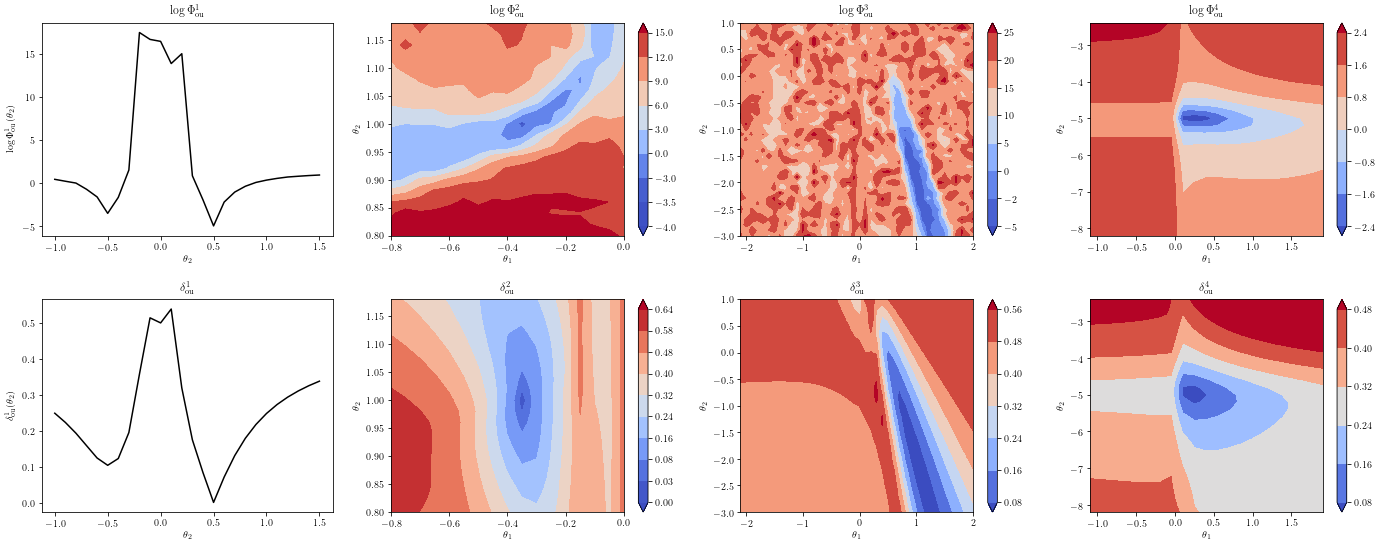

In [173]:
'''Plots for Monomial Discordance (12) and the SigCumulant-Contrast Function (13) (Ornstein-Uhlenbeck Source)'''

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(hspace = 0.3)

plt.figure(figsize=(24,9)) 
ax = plt.subplot(gs[0,0])
plt.plot(theta.y1,np.log(phi_1ou[1,:]), color='black')
ax.set_title(r'$\log\Phi^1_\mathrm{ou}$')
ax.set_xlabel(r'$\theta_2$')
ax.set_ylabel(r'$\log\Phi^1_\mathrm{ou}(\theta_2)$')
ax = plt.subplot(gs[1,0])
plt.plot(theta.y1,delta_1ou[1,:], color='black')
ax.set_title(r'$\delta^1_\mathrm{ou}$')
ax.set_xlabel(r'$\theta_2$')
ax.set_ylabel(r'$\delta^1_\mathrm{ou}(\theta_2)$')

ax = plt.subplot(gs[0,1])
th_meshx, th_meshy = np.meshgrid(theta.x2,theta.y2) 
profile1 = ax.contourf(th_meshx, th_meshy, np.log(phi_2ou).T, levels=[-4,-3.5,-3,0,3,6,9,12,15], cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile1, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\log\Phi^2_\mathrm{ou}$')
ax = plt.subplot(gs[1,1])
profile2 = ax.contourf(th_meshx, th_meshy, delta_2ou.T, levels=[0.00,0.03,0.08,0.16,0.24,0.32,0.40,0.48,0.58,0.64], cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile2, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\delta^2_\mathrm{ou}$')

ax = plt.subplot(gs[0,2])
th_meshx, th_meshy = np.meshgrid(theta.x3,theta.y3) 
profile1 = ax.contourf(th_meshx, th_meshy, np.log(phi_3ou).T, levels=[-5,-2,0,5,10,15,20,25], cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile1, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\log\Phi^3_\mathrm{ou}$')
ax = plt.subplot(gs[1,2])
profile2 = ax.contourf(th_meshx, th_meshy,delta_3ou.T, cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile2, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\delta^3_\mathrm{ou}$')

ax = plt.subplot(gs[0,3])
th_meshx, th_meshy = np.meshgrid(theta.x4,theta.y4) 
profile1 = ax.contourf(th_meshx, th_meshy, np.log(phi_4ou).T, cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile1, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\log\Phi^4_\mathrm{ou}$')
ax = plt.subplot(gs[1,3])
profile2 = ax.contourf(th_meshx, th_meshy, delta_4ou.T, cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile2, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\delta^4_\mathrm{ou}$')


Text(0.5, 1.0, '$\\delta^4_\\mathrm{cy}$')

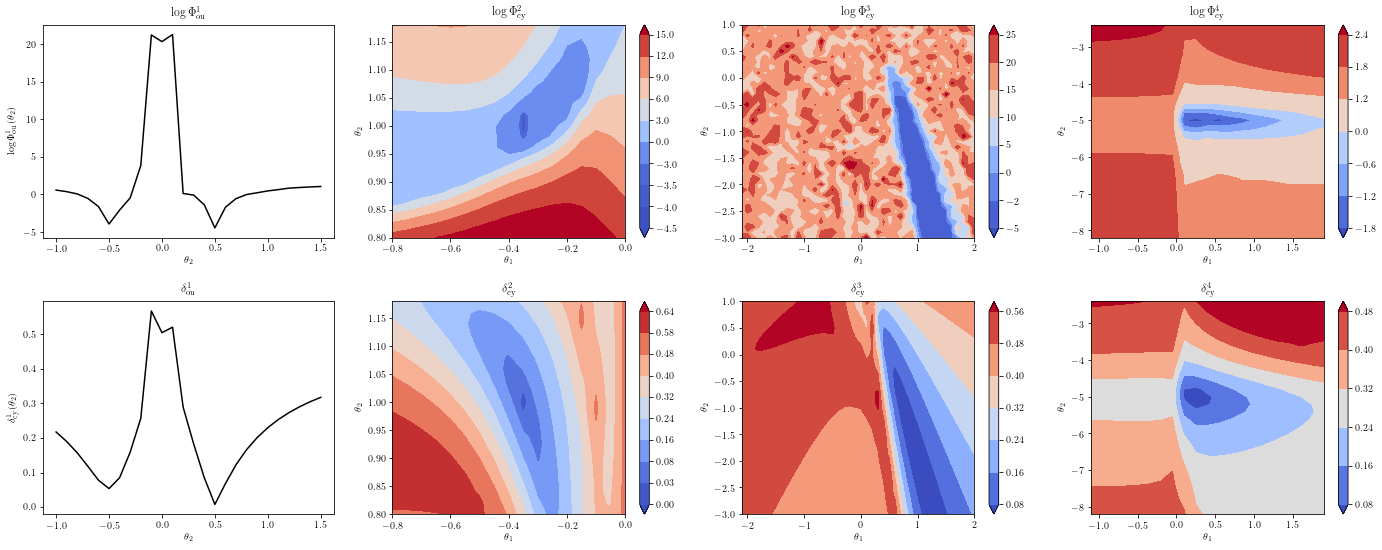

In [190]:
'''Plots for Monomial Discordance (12) and the SigCumulant-Contrast Function (13) (Copula-Based Time Series)'''

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(hspace = 0.3)

plt.figure(figsize=(24,9)) 
ax = plt.subplot(gs[0,0])
plt.plot(theta.y1,np.log(phi_1cy[1,:]), color='black')
ax.set_title(r'$\log\Phi^1_\mathrm{ou}$')
ax.set_xlabel(r'$\theta_2$')
ax.set_ylabel(r'$\log\Phi^1_\mathrm{ou}(\theta_2)$')
ax = plt.subplot(gs[1,0])
plt.plot(theta.y1,delta_1cy[1,:], color='black')
ax.set_title(r'$\delta^1_\mathrm{ou}$')
ax.set_xlabel(r'$\theta_2$')
ax.set_ylabel(r'$\delta^1_\mathrm{cy}(\theta_2)$')

ax = plt.subplot(gs[0,1])
th_meshx, th_meshy = np.meshgrid(theta.x2,theta.y2) 
profile1 = ax.contourf(th_meshx, th_meshy, np.log(phi_2cy).T, levels=[-4.5,-4,-3.5,-3,0,3,6,9,12,15], cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile1, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\log\Phi^2_\mathrm{cy}$')
ax = plt.subplot(gs[1,1])
profile2 = ax.contourf(th_meshx, th_meshy, delta_2cy.T, levels=[0.00,0.03,0.08,0.16,0.24,0.32,0.40,0.48,0.58,0.64], cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile2, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\delta^2_\mathrm{cy}$')

ax = plt.subplot(gs[0,2])
th_meshx, th_meshy = np.meshgrid(theta.x3,theta.y3) 
profile1 = ax.contourf(th_meshx, th_meshy, np.log(phi_3cy).T, levels=[-5,-2,0,5,10,15,20,25], cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile1, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\log\Phi^3_\mathrm{cy}$')
ax = plt.subplot(gs[1,2])
profile2 = ax.contourf(th_meshx, th_meshy,delta_3cy.T, cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile2, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\delta^3_\mathrm{cy}$')

ax = plt.subplot(gs[0,3])
th_meshx, th_meshy = np.meshgrid(theta.x4,theta.y4) 
profile1 = ax.contourf(th_meshx, th_meshy, np.log(phi_4cy).T, levels=[-1.8,-1.2,-0.6,0,1.2,1.8,2.4], cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile1, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\log\Phi^4_\mathrm{cy}$')
ax = plt.subplot(gs[1,3])
profile2 = ax.contourf(th_meshx, th_meshy, delta_4cy.T, cmap=plt.cm.coolwarm,extend='both')
plt.colorbar(profile2, ax=ax)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$\delta^4_\mathrm{cy}$')


# Experiments II: Mixings with Inverses estimated via Neural Networks

To underline the practicability of our method, we consider two nonlinear mixing transformations whose inverse will be estimated by optimising the sig-cumulant contrast ([13](#mjx-eqn-experI:eq13)) over an artificial neural network (ANN). 

### Method

Given an observable $X=f(S)$, we establish a differentiable connection between a feed-forward Artificial Neural Network (ANN) 

\begin{equation}\label{experII:eq3}\tag{14}
g\equiv (g_\theta : \mathbb{R}^m\rightarrow\mathbb{R}^m\mid \theta\in\tilde{\Theta})
\end{equation}

and our SigCumulant-based independence criterion $\phi_\mu\equiv\phi_\mu(Y)$ via the basic architecture

\begin{equation}\label{experII:eq1}\tag{15}
\Phi_X(\theta)\ := \ \phi_\mu(g_\theta(X)) \ \stackrel{!}{=} \ \varphi_\mu\,\circ\,\left(\mathfrak{S}\circ g_\theta\right)\,\circ\, X \qquad\text{for a suitably defined loss-function}\quad \varphi_\mu.
\end{equation}

(In the above, $\mathfrak{S} : BV(\mathbb{I};\mathbb{R}^d)\rightarrow\mathbb{R}[d]^\star$ is the signature transform over paths of bounded variation.)

The resulting estimate $\hat{g}$ of the inverse $f^{-1}$, whose accuracy crucially depends on the approximation-capacity of the given ANN $g$, then reads

\begin{equation}\label{experII:e2}\tag{16}
\hat{g} \ := \ g_{\theta^\ast} \quad \text{ for }\quad \theta^\ast\in\underset{\theta\in\tilde{\Theta}}{\operatorname{arg \, min}}\,\Phi_X(\theta);
\end{equation}

the associated estimate $\hat{S}$ of the $X$-underlying source $S$ is consequently given by $\hat{S}:=\hat{g}(X)$.

Practicable functions $\Phi_X$ and $\varphi_\mu$ as in ([15](#mjx-eqn-experII:eq1)) are derived and implemented in the notebook $\hl{...}$ and collected in the file $\texttt{SigIC_ANN.py}$.

Some IC source processes and the mixing transformations we apply to them are given below.

### Mixing Transformations

In [4]:
'''Nonlinear Mixing Transformations to Reverse via Neural Networks:'''

# Mixing A, f : \R^2 --> \R^2:
M1 = np.asarray([[0.94211376, 0.14512117],[0.42407973, 0.78168134]])
def NNmixA(x):
    y = inv_aux(f_1(1.1*x), M1, np.asarray([1,-0.35]))
    return LinTrafo(M1,y) 

# Mixing B, f : \R^4 --> \R^4: this mixing is defined by an invertible ANN on \R^4.

# define Mixing Model:
class mix_model(nn.Module): # 4-layer mixing, 4-dim input
    def __init__(self, d):
        h = d # d = n_in = n_out; l = 4 (number of layers; ~'degree of nonlinearity')
        # number of inputs/outputs [n_in/n_out], number of neurons in hidden layers [hi]
        super(mix_model, self).__init__() 
        self.l1 = nn.Linear(d, h)
        self.l2 = nn.Linear(h, h)
        self.l3 = nn.Linear(h, h)
        self.l4 = nn.Linear(h, d)
    
    # Forward Propagation:
    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = torch.tanh(self.l3(x))
        x = torch.tanh(self.l4(x))
        return x
    
# instantiate mixing model:
torch.manual_seed(5) 
NNmixB = mix_model(4)
NNmixB.float()


mix_model(
  (l1): Linear(in_features=4, out_features=4, bias=True)
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (l3): Linear(in_features=4, out_features=4, bias=True)
  (l4): Linear(in_features=4, out_features=4, bias=True)
)

In [5]:
print('Mixing Map B Invertible?')
a = torch.det(NNmixB.l1.weight)*torch.det(NNmixB.l2.weight)*torch.det(NNmixB.l3.weight)*torch.det(NNmixB.l4.weight).item()
print('-->', (torch.abs(a)>1e-9).item())

Mixing Map B Invertible?
--> True


### Sources and Observables

In [6]:
''' Sources for Mixing A'''

# Copula-based time series of Clayton type (source-type 1): 
r('''
set.seed(12)
nobs = 1000000 # number of observations

S_1cy <- Clayton.Markov.DATA(n=nobs,mu=0,sigma=1,alpha=0.5)
S_2cy <- Clayton.Markov.DATA(n=nobs,mu=0,sigma=1,alpha=1.5)
''')
S_1cy = r('S_1cy')
S_2cy = r('S_2cy')
S_1cy = 1/(np.max(np.abs(S_1cy)))*S_1cy
S_2cy = 1/(np.max(np.abs(S_2cy)))*S_2cy
S_cy = np.vstack((S_1cy, S_2cy)).transpose() # --> (nobs, d)-array

# Stationary Ornstein-Uhlenbeck processes (source-type 2):
r('''
set.seed(12)
# Source Component 1
th1_1 <- 0  #20
th1_2 <- 250 # Set high speed of reversion ("high stationarity")
th1_3 <- 1
d1 <- expression(th1_1 - th1_2 * x)
s1 <- expression(th1_3)
S_1ou <- -5*sde.sim(X0=rsOU(n=1, theta=c(th1_1,th1_2,th1_3)), N=nobs, M=1, drift=d1, sigma=s1)

# Source Component 2
th2_1 <- 0
th2_2 <- 120 # Set high speed of reversion ("high stationarity")
th2_3 <- 5
d2 <- expression(th2_1 - th2_2 * x)
s2 <- expression(th2_3)
S_2ou <- sde.sim(X0=rsOU(n=1, theta=c(th2_1,th2_2,th2_3)), N=nobs, M=1, drift=d2, sigma=s2)
''')
S_1ou = r('S_1ou')
S_2ou = r('S_2ou')
S_1ou = 1/(np.max(np.abs(S_1ou)))*S_1ou
S_2ou = 1/(np.max(np.abs(S_2ou)))*S_2ou
S_ou = np.vstack((S_1ou, S_2ou)).transpose() # --> (nobs, d)-array 

####################################################################################################

''' Source for Mixing B'''
r('''
set.seed(12345)
nobs = 250000
# Source Component 1
th1_1 <- 0  #20
th1_2 <- 250 # Set high speed of reversion ("high stationarity")
th1_3 <- 1
d1 <- expression(th1_1 - th1_2 * x)
s1 <- expression(th1_3)
S1 <- -5*sde.sim(X0=rsOU(n=1, theta=c(th1_1,th1_2,th1_3)), N=nobs, M=1, drift=d1, sigma=s1)

# Source Component 2
th2_1 <- 0
th2_2 <- 120 # Set high speed of reversion ("high stationarity")
th2_3 <- 5
d2 <- expression(th2_1 - th2_2 * x)
s2 <- expression(th2_3)
S2 <- sde.sim(X0=rsOU(n=1, theta=c(th2_1,th2_2,th2_3)), N=nobs, M=1, drift=d2, sigma=s2)

# Source Component 3
th3_1 <- 0
th3_2 <- 200 # Set high speed of reversion ("high stationarity")
th3_3 <- 3
d3 <- expression(th3_1 - th3_2 * x)
s3 <- expression(th3_3)
S3 <- sde.sim(X0=rsOU(n=1, theta=c(th3_1,th3_2,th3_3)), N=nobs, M=1, drift=d3, sigma=s3)

# Source Component 4
th4_1 <- 0
th4_2 <- 160 # Set high speed of reversion ("high stationarity")
th4_3 <- 2
d4 <- expression(th3_1 - th3_2 * x)
s4 <- expression(th3_3)
S4 <- sde.sim(X0=rsOU(n=1, theta=c(th4_1,th4_2,th4_3)), N=nobs, M=1, drift=d4, sigma=s4)
''')
S1_4D = r('S1')
S2_4D = r('S2')
S3_4D = r('S3')
S4_4D = r('S4')
S1_4D = 1/(np.max(np.abs(S1_4D)))*S1_4D
S2_4D = 1/(np.max(np.abs(S2_4D)))*S2_4D
S3_4D = 1/(np.max(np.abs(S3_4D)))*S3_4D
S4_4D = 1/(np.max(np.abs(S4_4D)))*S4_4D
S4D  = np.vstack((S1_4D,S2_4D,S3_4D,S4_4D)).transpose() 


In [13]:
'''Specify Size of Input Data (= Number of Data Points for X) and Clip the Signals'''
N_dat = 250000
S_ou  = S_ou[:N_dat]
S_cy  = S_cy[:N_dat]

'''Observables X = f(S)'''
X_Aou = torch.from_numpy(NNmixA(S_ou)).float() #require torch tensors for python-based ANN-functionality
X_Acy = torch.from_numpy(NNmixA(S_cy)).float()
X_B   = NNmixB(torch.from_numpy(S4D).float()).float()

# Rescale data 
X_Aou = sigic.rescale(X_Aou)
X_Acy = sigic.rescale(X_Acy)


As the concordance matrices of X and S do not resemble permutation matrices, the resulting mixtures A and B are non-trivial:

In [126]:
ConcordAou = mondis.ConcordanceMatrix(X_Aou.numpy(),S_ou,100,1,'kendall')
ConcordAcy = mondis.ConcordanceMatrix(X_Acy.numpy(),S_cy,100,1,'kendall')
ConcordB   = mondis.ConcordanceMatrix(X_B.detach().numpy(),S4D,100,1,'kendall')
print("Concordance of X_Aou and S_ou:\n",ConcordAou)
print("")
print("Concordance of X_Acy and S_cy:\n",ConcordAcy)
print("")
print("Concordance of X_B and S4D:\n",ConcordB)

Concordance of X_Aou and S_ou:
 [[0.50148535 0.63937339]
 [0.37379701 0.47457734]]

Concordance of X_Acy and S_cy:
 [[0.42442685 0.57253903]
 [0.4308055  0.57109593]]

Concordance of X_B and S4D:
 [[0.44614763 0.25556538 0.01497395 0.46259092]
 [0.21765784 0.27647315 0.10749615 0.55394388]
 [0.21013703 0.17748263 0.56755296 0.2452516 ]
 [0.19959478 0.17081962 0.32942072 0.58363029]]


### Artificial Neural Networks Modelling Candidate Demixing-Functions

The two ANNs ([14](#mjx-eqn-experII:eq3)) we consider are instantiated from the following (ad hoc) models.

In [14]:
'''Feedforward-Models for Demixing-ANNs (14)'''

class demixA(nn.Module):
    def __init__(self, n_in, h1, h2, n_out):
        # number of inputs/outputs [n_in/n_out], number of neurons in hidden layers [hi]
        super(demixA, self).__init__() 
        self.l1 = nn.Linear(n_in, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, n_out)
    
    # Forward Propagation:
    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = torch.tanh(self.l3(x))
        return x
    
class demixB(nn.Module): # Single-Layer NN
    def __init__(self, n_in, h1, n_out):
        # number of inputs/outputs [n_in/n_out], number of neurons in hidden layers [hi]
        super(demixB, self).__init__() 
        self.l1 = nn.Linear(n_in, h1)
        self.l2 = nn.Linear(h1, n_out)
    
    # Forward Propagation:
    def forward(self, x):
        x = nn.LeakyReLU(0.5)(self.l1(x))
        x = nn.LeakyReLU(0.5)(self.l2(x))
        return x


In [138]:
'''Demixing-ANN for Mixing A'''
torch.manual_seed(1234) # choose random initial configuration of ANN
g1   = demixA(2,4,32,2)
g1.float()                # model for the inversion of X_Aou

demixA(
  (l1): Linear(in_features=2, out_features=4, bias=True)
  (l2): Linear(in_features=4, out_features=32, bias=True)
  (l3): Linear(in_features=32, out_features=2, bias=True)
)

In [167]:
torch.manual_seed(10) # choose random initial configuration of ANN
g1cy = demixA(2,32,128,2)
g1cy.float()   # model for the inversion of X_Acy

demixA(
  (l1): Linear(in_features=2, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=2, bias=True)
)

In [130]:
'''Demixing-ANN for Mixing B'''
torch.manual_seed(1) 
g2 = demixB(4,1024,4)
g2.float()

demixB(
  (l1): Linear(in_features=4, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=4, bias=True)
)

### Specification of the Loss Functions ([15](#mjx-eqn-experII:eq1))

In [131]:
'''Specification of (15) (loss function)'''

'''Mixing A:'''
dA  = 2                # mixing-dimension
mA  = 6                # orders for control-tuple
muA = np.asarray([mA]) # control-tuple
blA = 50                # batchlength

# coefficient matrices (see \hl{Sigtorch_jupyter_notebook} for details):
C1A,C2A,C3A = sigNN.coeffMats(muA) 

# varphi_mu (as in (15)):
def phimuA(t):
    '''Input: t [torch.tensor of shape (d_m,)] ; requires C1,C2,C3 = coeffMats(mu) as auxiliary structures.
       Returns: \phi_\mu(t) as given by (\beta).'''
    
    q1 = torch.matmul(C1A,t)
    q2 = torch.exp(torch.matmul(C3A,torch.log(torch.matmul(C2A,t))))
    q3 = torch.div(q1,q2)
    c  = torch.sum(torch.pow(q3,2))
    
    return c

# phi_mu (as in (15)):
def SigICLossA(x,target):
    '''Input: collection of estimated (semi-lexic. indexed) signature coefficients S [torch.tensor of shape (N,d_m)];
              requires control tuple mu and coeff-matrices C1,C2,C3 = coeffMats(mu) as auxiliary structures.
       Returns: standardised cumulant-based contrast value barSigCF_mu(NN_theta(X)) (~ (6) on SigContrast.ipynb).'''

    # Compute ESig from x=NN(X):
    [N,d] = x.shape        
    Np    = N//blA      
    x     = x[:Np*blA] 
    xsp   = torch.split(x,blA) 
    xsp   = torch.stack(xsp) 
    sigx  = signatory.signature(xsp,mA)

    ESigX = torch.mean(sigx,0)  # estimate expected signature as row-wise arithmetic mean of input 
    ESigX = ESigX.unsqueeze(0)  # add extra dimension (signatory() requires input to be 2d, dims corr.to (batch,channels))
    
    # Compute log(ESig) and apply loss:
    logES = signatory.signature_to_logsignature(ESigX,dA,mA,mode='expand') #--> torch.tensor of shape(N',), ind.~(9)
    logES = logES.squeeze(0) #reduce superfluous first dimension (which was just needed for signatory())
    
    l     = phimuA(logES)
    
    return l 

###########################################################################################################################
###########################################################################################################################

'''Mixing B:'''
dB  = 4                      # mixing-dimension
mB  = 5                      # orders for control-tuple
muB = np.asarray([mB,mB,mB]) # control-tuple
blB = 10                     # batchlength

# coefficient matrices (see \hl{Sigtorch_jupyter_notebook} for details):
C1B,C2B,C3B = sigNN.coeffMats(muB) 

# varphi_mu (as in (15)):
def phimuB(t):
    '''Input: t [torch.tensor of shape (d_m,)] ; requires C1,C2,C3 = coeffMats(mu) as auxiliary structures.
       Returns: \phi_\mu(t) as given by (\beta).''' 
    
    q1 = torch.mv(C1B,t)
    qa = torch.mv(C2B,t)
    qb = torch.log(qa)
    qc = torch.mv(C3B,qb)
    q2 = torch.exp(qc)
    q3 = torch.div(q1,q2+1e-22) #'ad-hoc regularization': adding small epsilon in denominator to prevent nans
    c  = torch.sum(torch.pow(q3,2)) 
    
    return c

# phi_mu (as in (15)):
def SigICLossB(x,target):
    '''Input: collection of estimated (semi-lexic. indexed) signature coefficients S [torch.tensor of shape (N,d_m)];
              requires control tuple mu and coeff-matrices C1,C2,C3 = coeffMats(mu) as auxiliary structures.
       Returns: standardised cumulant-based contrast value barSigCF_mu(NN_theta(X)) (~ (6) on SigContrast.ipynb).'''

    # Compute ESig from x=NN(X):
    [N,dB] = x.shape        
    Np    = N//blB      
    x     = x[:Np*blB] 
    xsp   = torch.split(x,blB) 
    xsp   = torch.stack(xsp) 
    sigx  = signatory.signature(xsp,mB)

    ESigX = torch.mean(sigx,0)  # estimate expected signature as row-wise arithmetic mean of input 
    ESigX = ESigX.unsqueeze(0)  # add extra dimension (signatory() requires input to be 2d, dims corr.to (batch,channels))
    
    # Compute log(ESig) and apply loss:
    logES = signatory.signature_to_logsignature(ESigX,dB,mB,mode='expand') #--> torch.tensor of shape(N',), ind.~(9)
    logES = logES.squeeze(0) #reduce superfluous first dimension (which was just needed for signatory())
    
    l     = phimuB(logES)
    
    return l


## Training the Demixing-ANNs

### Training for the Inversion of Mixing $A_\mathrm{ou}$

In [143]:
'''Specify optimizer for the demixing-model:'''
optimizer1ou = torch.optim.Adam(g1.parameters(), lr=1e-3, weight_decay=1e-5)

In [148]:
'''Train the model'''
# Train the ANN g1 so as to minimize loss=SigICLoss():
x = X_Aou
# Specify number of epochs:
N_EPOCHS  = 30

# Train:
for epoch in range(1,N_EPOCHS+1):

    prediction = g1(x)     # input x and predict based on x

    loss = SigICLossA(prediction,0)     # must be (1. nn output, 2. target)
    #loss = Variable(loss, requires_grad=True)

    optimizer1ou.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer1ou.step()        # apply gradients

    print('loss = {:.4f}; training {:.2f}% complete   '.format(loss,epoch/N_EPOCHS*100), end="\r")
    time.sleep(0.1)

In [34]:
'Example training scheme for the ANN g1cy: (lr,w_d,N_Epochs) = (5e-2, 1e-3, 150) --> (1e-3, 1e-5, 50)'

# print accuracy of estimation (quantified by the Monomial Discordance Matrix of \hat{S} and S):
Y_ou = g1(X_Aou).detach()
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(Y_ou.numpy(),S_ou,100,1,'kendall'))
print("")
print("(Stopped) Loss of S^: ", sigic.SigCF(Y_ou,muA,blA).item())
print("True Loss of S: ", sigic.SigCF(torch.from_numpy(S_ou),muA,blA).item())

Monotone Concordance of S^ and S:
 [[0.15358407 0.94648609]
 [0.86378706 0.18388323]]

(Stopped) Loss of S^:  0.11380261182785034
True Loss of S:  0.005783562082797289


For convenience, a pre-trained ANN is imported below.

In [33]:
with open(os.getcwd()+'\\Simulation_Results\demixNN_Aou_ast.pickle','rb') as handle:
    g1 = pickle.load(handle)

### Training for the Inversion of Mixing $A_\mathrm{cy}$

In [180]:
torch.manual_seed(5) # choose random initial configuration of ANN
g1cy = demixA(2,4,32,2)
g1cy.float()   # model for the inversion of X_Acy

demixA(
  (l1): Linear(in_features=2, out_features=4, bias=True)
  (l2): Linear(in_features=4, out_features=32, bias=True)
  (l3): Linear(in_features=32, out_features=2, bias=True)
)

In [181]:
'''Specify optimizer for the demixing-model:'''
optimizer1cy = torch.optim.Adam(g1cy.parameters(), lr=1e-2, weight_decay=1e-3)

In [182]:
'''Train the model'''
# Train the ANN g1 so as to minimize loss=SigICLoss():
x = X_Acy
# Specify number of epochs:
N_EPOCHS  = 50

# Train:
for epoch in range(1,N_EPOCHS+1):

    prediction = g1cy(x)     # input x and predict based on x

    loss = SigICLossA(prediction,0)     # must be (1. nn output, 2. target)
    #loss = Variable(loss, requires_grad=True)

    optimizer1cy.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer1cy.step()        # apply gradients

    print('loss = {:.4f}; training {:.2f}% complete   '.format(loss,epoch/N_EPOCHS*100), end="\r")
    time.sleep(0.1)

In [36]:
'Possible training scheme for the ANN g1cy: (lr,w_d,N_Epochs) = (1e-2, 1e-3, 50)'

# print accuracy of estimation (quantified by the Monomial Discordance Matrix of \hat{S} and S):
Y_cy = g1cy(X_Acy).detach()
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(Y_cy.numpy(),S_cy,100,1,'kendall'))
print("")
print("(Stopped) Loss of S^: ", sigic.SigCF(Y_cy,muA,blA).item())
print("True Loss (of S): ", sigic.SigCF(torch.from_numpy(S_cy),muA,blA).item())

Monotone Concordance of S^ and S:
 [[0.13555673 0.85610428]
 [0.81175483 0.15411929]]

(Stopped) Loss of S^:  0.025133883580565453
True Loss (of S):  0.006887000985443592


For convenience, a pre-trained ANN is imported below.

In [35]:
with open(os.getcwd()+'\\Simulation_Results\demixNN_Acy_ast.pickle','rb') as handle:
    g1cy = pickle.load(handle)

### Training for the Inversion of Mixing $B$

In [190]:
'''Demixing-ANN for Mixing B'''
torch.manual_seed(1) 
g2 = demixB(4,1024,4)
g2.float()

demixB(
  (l1): Linear(in_features=4, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=4, bias=True)
)

In [191]:
'''Specify optimizer for the demixing-model:'''
optimizer2 = torch.optim.Adam(g2.parameters(), lr=5*1e-2, weight_decay=1e-3)

In [ ]:
'''Train the model'''
# Train the ANN g1 so as to minimize loss=SigICLoss():
x = X_B
# Specify number of epochs:
N_EPOCHS  = 150

# Train:
for epoch in range(1,N_EPOCHS+1):

    prediction = g2(x)     # input x and predict based on x

    loss = SigICLossB(prediction,0)     # must be (1. nn output, 2. target)
    #loss = Variable(loss, requires_grad=True)

    optimizer2.zero_grad()            # clear gradients for next train
    loss.backward(retain_graph=True)  # backpropagation, compute gradients
    optimizer2.step()                 # apply gradients

    print('loss = {:.4f}; training {:.2f}% complete   '.format(loss,epoch/N_EPOCHS*100))
    time.sleep(0.1)

In [38]:
'Possible training scheme for the ANN g1cy: (lr,w_d,N_Epochs) = (1e-2, 0, 180) 1 --> (1e-3, 0.1, 100) 2  --> (1e-2, 0.1, 50) 3 --> (1e-3, 0.1, 200) 4'

# print accuracy of estimation (quantified by the Monomial Discordance Matrix of \hat{S} and S):
Y_B = g2(X_B).detach()
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(Y_B.numpy(),S4D,100,1,'kendall'))
print("")
print("(Stopped) Loss of S^: ", sigic.SigCF(Y_B,muB,blB).item())
print("True Loss (of S): ", sigic.SigCF(torch.from_numpy(S4D),muB,blB).item())

Monotone Concordance of S^ and S:
 [[0.14832602 0.72510403 0.10851107 0.06870473]
 [0.0374511  0.03389674 0.80331689 0.26499105]
 [0.83372396 0.00264667 0.03727134 0.01648037]
 [0.07688304 0.13052942 0.07164702 0.78666867]]

(Stopped) Loss of S^:  0.9279083013534546
True Loss (of S):  0.018998323008418083


For convenience, a pre-trained ANN is imported below.

In [37]:
with open(os.getcwd()+'\\Simulation_Results\demix_NNB_ast.pickle','rb') as handle:
    g2 = pickle.load(handle)

## Plot of Results

In [204]:
'''Collect Trained Results'''
Y_ou = g1(X_Aou).detach().numpy()
Y_cy = g1cy(X_Acy).detach().numpy()
Y_B  = g2(X_B).detach().numpy()

The following plots are exported as Figures 6 and 7 of the paper, respectively.

### Inversion of Mixing A

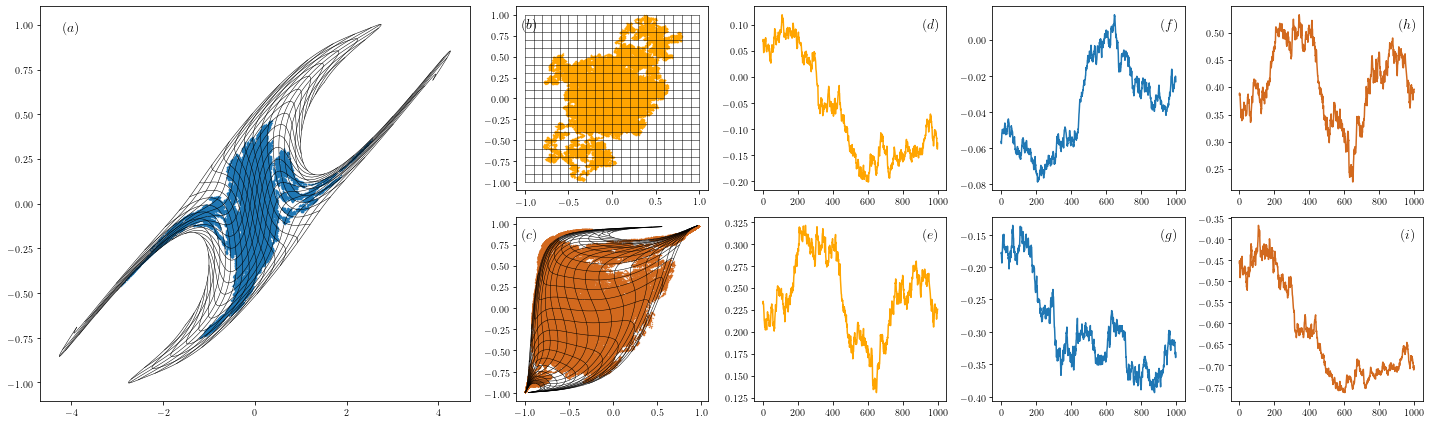

In [41]:
'''Plot Results for Mixing A_ou'''
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 6)

N  = 250000
t0 = 10000
t1 = t0 + 1000

plt.figure(figsize=(20,6))
ax = plt.subplot(gs[0:2, 0:2])
grid_f1 = NNmixA(lines)
plt.axis("on")
for line in grid_f1:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")
X_Aou_noscale = torch.from_numpy(NNmixA(S_ou)).float()
plt.scatter(X_Aou_noscale[:N,0], X_Aou_noscale[:N,1], s=0.1,rasterized=True)
plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
  
ax = plt.subplot(gs[0:1,2:3])
g0_lines = lines
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = t.float().T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(t[0], t[1], linewidth=0.5, color="k")
plt.scatter(S_ou[:N,0], S_ou[:N,1],s=0.1,c='orange', rasterized=True)
plt.text(0.075, 0.9,'$(b)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[1:2,2:3])
g0_lines = sigic.rescale(torch.from_numpy(NNmixA(lines)))
g0_lines = g0_lines.numpy()
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = g1(t.float()).T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(-t[1], t[0], linewidth=0.5, color="k")
plt.scatter(-Y_ou[:N,1],Y_ou[:N,0],s=0.1,c='chocolate',rasterized=True)
plt.text(0.075, 0.9,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[0,3])
plt.plot(S_ou[t0:t1,0], c='orange')
plt.text(0.925, 0.9,'$(d)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,3])
plt.plot(S_ou[t0:t1,1], c='orange')
plt.text(0.925, 0.9,'$(e)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,4])
plt.plot(X_Aou[t0:t1,0])
plt.text(0.925, 0.9,'$(f)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,4])
plt.plot(X_Aou[t0:t1,1])
plt.text(0.925, 0.9,'$(g)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,5])
plt.plot(Y_ou[t0:t1,0], c='chocolate')
plt.text(0.925, 0.9,'$(h)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,5])
plt.plot(-Y_ou[t0:t1,1], c='chocolate')
plt.text(0.925, 0.9,'$(i)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
plt.tight_layout()

#plt.savefig('NN_2D_ou.pdf', dpi=300)

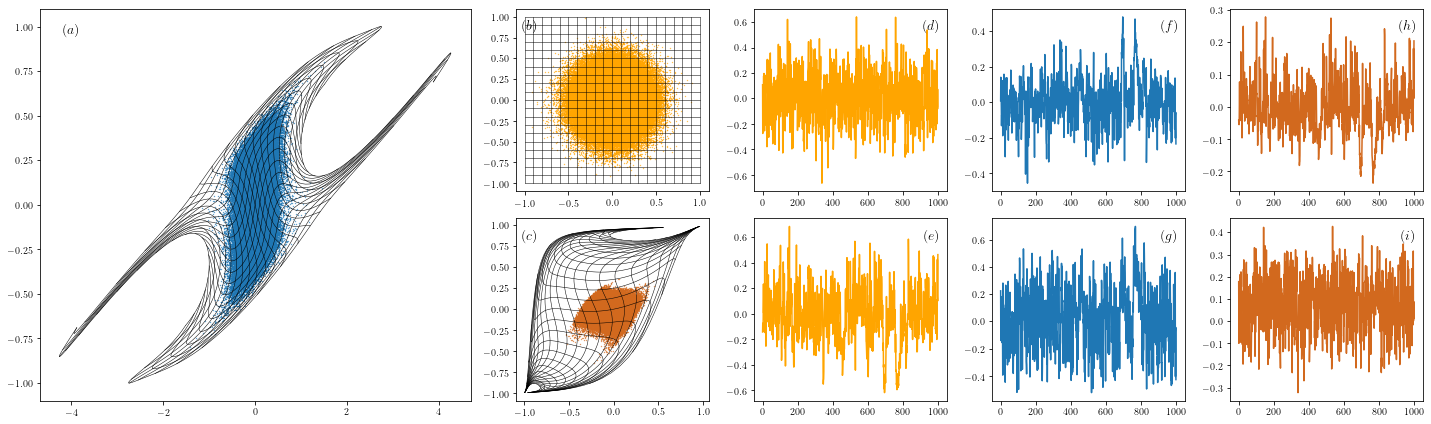

In [216]:
'''Plot Results for Mixing A_cy'''
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 6)

N  = 250000
t0 = 10000
t1 = t0 + 1000

plt.figure(figsize=(20,6))
ax = plt.subplot(gs[0:2, 0:2])
grid_f1 = NNmixA(lines)
plt.axis("on")
for line in grid_f1:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")
X_Acy_noscale = torch.from_numpy(NNmixA(S_cy)).float()
plt.scatter(X_Acy_noscale[:N,0], X_Acy_noscale[:N,1], s=0.1,rasterized=True)
plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
  
ax = plt.subplot(gs[0:1,2:3])
g0_lines = lines
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = t.float().T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(t[0], t[1], linewidth=0.5, color="k")
plt.scatter(S_cy[:N,0], S_cy[:N,1],s=0.1,c='orange', rasterized=True)
plt.text(0.075, 0.9,'$(b)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[1:2,2:3])
g0_lines = sigic.rescale(torch.from_numpy(NNmixA(lines)))
g0_lines = g0_lines.numpy()
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = g1(t.float()).T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(-t[1], t[0], linewidth=0.5, color="k")
plt.scatter(-Y_cy[:N,1],Y_cy[:N,0],s=0.1,c='chocolate',rasterized=True)
plt.text(0.075, 0.9,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[0,3])
plt.plot(S_cy[t0:t1,0], c='orange')
plt.text(0.925, 0.9,'$(d)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,3])
plt.plot(S_cy[t0:t1,1], c='orange')
plt.text(0.925, 0.9,'$(e)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,4])
plt.plot(X_Acy[t0:t1,0])
plt.text(0.925, 0.9,'$(f)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,4])
plt.plot(X_Acy[t0:t1,1])
plt.text(0.925, 0.9,'$(g)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,5])
plt.plot(-Y_cy[t0:t1,0], c='chocolate')
plt.text(0.925, 0.9,'$(h)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,5])
plt.plot(Y_cy[t0:t1,1], c='chocolate')
plt.text(0.925, 0.9,'$(i)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
plt.tight_layout()

#plt.savefig('NN_2D_cy.pdf', dpi=300)

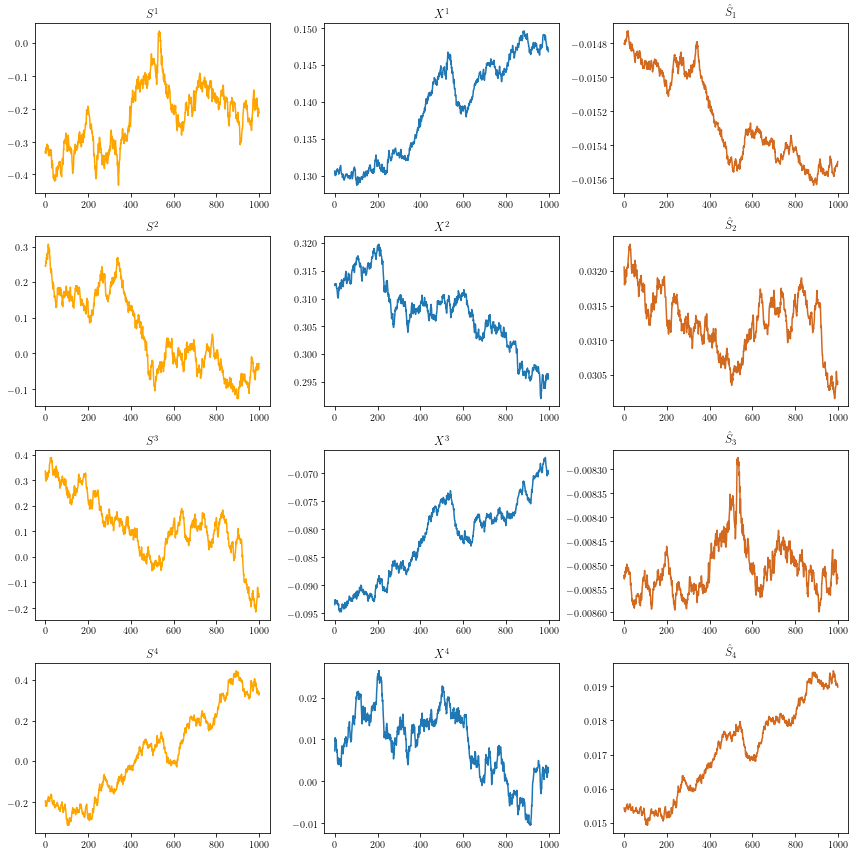

In [42]:
'''Plot Results for Mixing B'''
import matplotlib.gridspec as gridspec
gs    = gridspec.GridSpec(4, 3)

t0    = 10000
t1    = t0 + 1000

plt.figure(figsize=(12,12))
ax = plt.subplot(gs[0, 0])
plt.plot(S4D[t0:t1,0], c='orange')
plt.title(r'$S^1$')

ax = plt.subplot(gs[1, 0])
plt.plot(S4D[t0:t1,1], c='orange')
plt.title(r'$S^2$')

ax = plt.subplot(gs[2, 0])
plt.plot(S4D[t0:t1,2], c='orange')
plt.title(r'$S^3$')

ax = plt.subplot(gs[3, 0])
plt.plot(S4D[t0:t1,3], c='orange')
plt.title(r'$S^4$')
#######################################
ax = plt.subplot(gs[0, 1])
plt.plot(X_B.detach()[t0:t1,0])
plt.title(r'$X^1$')

ax = plt.subplot(gs[1, 1])
plt.plot(X_B.detach()[t0:t1,1])
plt.title(r'$X^2$') 

ax = plt.subplot(gs[2, 1])
plt.plot(X_B.detach()[t0:t1,2])
plt.title(r'$X^3$') 

ax = plt.subplot(gs[3, 1])
plt.plot(X_B.detach()[t0:t1,3])
plt.title(r'$X^4$')   
#######################################
ax = plt.subplot(gs[0, 2])
plt.plot(Y_B[t0:t1,0], c='chocolate')
plt.title(r'$\hat{S}_1$')

ax = plt.subplot(gs[1, 2])
plt.plot(Y_B[t0:t1,1], c='chocolate')
plt.title(r'$\hat{S}_2$')  

ax = plt.subplot(gs[2, 2])
plt.plot(Y_B[t0:t1,2], c='chocolate')
plt.title(r'$\hat{S}_3$')   

ax = plt.subplot(gs[3, 2])
plt.plot(Y_B[t0:t1,3], c='chocolate')
plt.title(r'$\hat{S}_4$')

plt.tight_layout()

#plt.savefig('NN_4D.pdf')